In [1]:
import os
os.chdir("../../")

import numpy as np
import pandas as pd
from scripts.utils import *
from scripts.parsing import *
from scripts.evaluate import *

In [2]:
benchmarks = ["SST-2", "CoLA", "AGNews", "MRPC", "SNLI", "WiC"]
models = ['meta-llama/Llama-3-70b-chat-hf', 'mistralai/Mixtral-8x7B-Instruct-v0.1', 'gpt-3.5-turbo-0125',
          'meta-llama/Llama-3-8b-chat-hf', 'mistralai/Mistral-7B-Instruct-v0.2', 'gpt-4-turbo-2024-04-09', 'lmsys/vicuna-13b-v1.5']
tasks = ["single_clf", "batch_clf", "index_selection_one_cat_a_time", "index_selection_one_cat_a_time_json", 
         "index_selection_all_cat_at_once", "index_selection_all_cat_at_once_adjusted"]

In [3]:
# prp_df, evaled_df = get_parse_rate_and_performance(benchmarks, models, tasks, CoT=[False], return_evaluated_df=True)
evaled_df = pd.read_json("results/main_clf_results.json", lines=True)

In [4]:
prp_df = pd.read_csv("results/main_results_parse_rate_and_performance.csv")
# evaled_df = pd.read_json("results/main_clf_results.json", lines=True)

In [5]:
def get_parse_rate_and_performance(benchmarks, models, df, CoT=[False]):
    out = []
    cols = ["benchmark", "task", "taskSize", "model", "CoT", "#shot", "parse_rate", "performance"]

    for benchmark in benchmarks:

        for task in tasks:
            sub = df.copy()[(df.task == task) & (df.benchmark == benchmark)]
            taskSizes = sub.taskSize.unique()

            for taskSize in taskSizes:

                subsub = sub.copy()[sub.taskSize == taskSize]

                for cot in CoT:
                    subsubsub = subsub.copy()[subsub.CoT == cot]
                    for num_shot in subsubsub["#shot"].unique():
                        subsubsubsub = subsubsub.copy()[subsubsub["#shot"] == num_shot]
                        for model in models:
                            parsed = subsubsubsub[subsubsubsub.model == model]["parsed"]
                            parse_rate = (parsed != "CANNOT_PARSE").mean()
                            performance = subsubsubsub[subsubsubsub.model == model]["perTaskAccu"].mean()
                            out.append([benchmark, task, taskSize, model, cot, num_shot, parse_rate, performance])
    
    out = pd.DataFrame(out, columns=cols)
    return out

In [14]:
prp_df[(prp_df.benchmark == "CoLA") &
       # (prp_df.task == "batch_clf") &
       (prp_df.taskSize <= 5) &
       (prp_df.model == "GPT-3.5")]

,benchmark,task,taskSize,model,CoT,#shot,parse_rate,performance
184,CoLA,single_clf,1,GPT-3.5,False,0,1.000,0.841802
191,CoLA,batch_clf,5,GPT-3.5,False,0,1.000,0.796000
226,CoLA,index_selection_one_cat_a_time,5,GPT-3.5,False,0,1.000,0.634000
261,CoLA,index_selection_one_cat_a_time_json,5,GPT-3.5,False,0,0.995,0.664000
296,CoLA,index_selection_all_cat_at_once,5,GPT-3.5,False,0,1.000,0.762000


In [18]:
evaled_df.model.unique()

array(['meta-llama/Llama-3-70b-chat-hf',
       'mistralai/Mixtral-8x7B-Instruct-v0.1', 'gpt-3.5-turbo-0125',
       'meta-llama/Llama-3-8b-chat-hf',
       'mistralai/Mistral-7B-Instruct-v0.2', 'gpt-4-turbo-2024-04-09',
       'lmsys/vicuna-13b-v1.5'], dtype=object)

In [19]:
evaled_df[(evaled_df.benchmark == "CoLA") & 
          (evaled_df.task == "batch_clf") & 
          (evaled_df.taskSize == 5) &
          (evaled_df.model == "gpt-3.5-turbo-0125")]["#dif"].mean()

0.0

In [16]:
# prp_df = get_parse_rate_and_performance(benchmarks, models, evaled_df, CoT=[False])
# prp_df

In [30]:
# model_renamer = {"meta-llama/Llama-3-70b-chat-hf": "Llama-3 70B", "mistralai/Mixtral-8x7B-Instruct-v0.1": "Mixtral 8x7B", 
#                  "gpt-3.5-turbo-0125": "GPT-3.5", "meta-llama/Llama-3-8b-chat-hf": "Llama-3 8B", 
#                  "mistralai/Mistral-7B-Instruct-v0.2": "Mistral 7B", "gpt-4-turbo-2024-04-09": "GPT-4", 
#                  "lmsys/vicuna-13b-v1.5": "Vicuna", "random baseline": "Random Baseline"}

# prp_df.model = prp_df.model.map(model_renamer)

In [31]:
model_renamer

{'meta-llama/Llama-3-70b-chat-hf': 'Llama-3 70B',
 'mistralai/Mixtral-8x7B-Instruct-v0.1': 'Mixtral 8x7B',
 'gpt-3.5-turbo-0125': 'GPT-3.5',
 'meta-llama/Llama-3-8b-chat-hf': 'Llama-3 8B',
 'mistralai/Mistral-7B-Instruct-v0.2': 'Mistral 7B',
 'gpt-4-turbo-2024-04-09': 'GPT-4',
 'lmsys/vicuna-13b-v1.5': 'Vicuna',
 'random baseline': 'Random Baseline'}

In [5]:
prp_df.model = prp_df.model.map(lambda t: t if t != "Vicuna 13B" else "Vicuna")
prp_df.model.unique()

array(['Llama-3 70B', 'Mixtral 8x7B', 'GPT-3.5', 'Llama-3 8B',
       'Mistral 7B', 'GPT-4', 'Vicuna'], dtype=object)

In [6]:
prp_df[prp_df.task.isin(tasks)].benchmark.value_counts()

SST-2     182
MRPC      182
SNLI      182
WiC       182
CoLA      147
AGNews    147
Name: benchmark, dtype: int64

In [7]:
prp_df[~prp_df.benchmark.isin(["CoLA", "AGNews"])].task.value_counts() // 4

batch_clf                                   35
index_selection_one_cat_a_time              35
index_selection_one_cat_a_time_json         35
index_selection_all_cat_at_once             35
index_selection_all_cat_at_once_adjusted    35
single_clf                                   7
Name: task, dtype: int64

In [8]:
prp_df[prp_df.benchmark.isin(["CoLA", "AGNews"])].task.value_counts() // 2

batch_clf                              35
index_selection_one_cat_a_time         35
index_selection_one_cat_a_time_json    35
index_selection_all_cat_at_once        35
single_clf                              7
Name: task, dtype: int64

In [9]:
# prp_df.to_csv("results/main_results_parse_rate_and_performance.csv", index=False)

In [10]:
task_renamer = {"single_clf": "SingleClf", "batch_clf": "BatchClf", 
                "index_selection_one_cat_a_time_json": "SelectOne", 
                "index_selection_all_cat_at_once_adjusted": "SelectAll"}

prp_df_adjusted = prp_df.copy()[(prp_df.task != "index_selection_one_cat_a_time") 
                                 & (prp_df.model != "Random Baseline")]
 
prp_df_adjusted = prp_df_adjusted.copy()[~((prp_df_adjusted.model == "Vicuna") & 
                                           (prp_df_adjusted.benchmark == "AGNews") & 
                                           (prp_df_adjusted.taskSize == 100))]
                                 
prp_df_adjusted.task = prp_df_adjusted.apply(lambda row: "index_selection_all_cat_at_once_adjusted" 
                                             if row.benchmark in ["CoLA", "AGNews"] and 
                                             row.task == "index_selection_all_cat_at_once" 
                                             else row.task, axis=1)

prp_df_adjusted = prp_df_adjusted.copy()[prp_df_adjusted.task != "index_selection_all_cat_at_once"]
prp_df_adjusted.task = prp_df_adjusted.task.map(task_renamer)

In [11]:
prp_df_adjusted.task.value_counts()

BatchClf     209
SelectOne    209
SelectAll    209
SingleClf     42
Name: task, dtype: int64

In [12]:
prp_df_adjusted.model.value_counts()

Llama-3 70B     96
Mixtral 8x7B    96
GPT-3.5         96
Llama-3 8B      96
Mistral 7B      96
GPT-4           96
Vicuna          93
Name: model, dtype: int64

## Overall results across the four tasks

In [13]:
prp_df_adjusted.model.unique()

array(['Llama-3 70B', 'Mixtral 8x7B', 'GPT-3.5', 'Llama-3 8B',
       'Mistral 7B', 'GPT-4', 'Vicuna'], dtype=object)

In [14]:
def get_overall_results_pv(benchmarks):
    overall_results = []
    cols = ["model", "task", "accuracy"]
    tasks = ["SingleClf", "BatchClf", "SelectOne", "SelectAll"]

    for task in tasks:
        sub = prp_df_adjusted.copy()[(prp_df_adjusted.task == task) & (prp_df_adjusted.benchmark.isin(benchmarks))]
        overall_results.append(["Overall", task, sub["performance"].mean()])
        
    models = ["Vicuna", "Mistral 7B", "Mixtral 8x7B", 
              "Llama-3 8B", "Llama-3 70B", "GPT-3.5", "GPT-4"]
    for model in models:
        sub = prp_df_adjusted.copy()[(prp_df_adjusted.model == model) & (prp_df_adjusted.benchmark.isin(benchmarks))]
        for task in tasks:
            subsub = sub.copy()[sub.task == task]
            acc = subsub["performance"].mean()
            overall_results.append([model, task, acc])

    models =  models + ["Overall"]
    overall_results_df = pd.DataFrame(overall_results, columns=cols)
    overall_results_df = overall_results_df.pivot(index="model", columns="task", values="accuracy")
    overall_results_df = overall_results_df.loc[models]
    overall_results_df = overall_results_df.round(3)
    overall_results_df = overall_results_df * 100
    overall_results_df = overall_results_df.astype(float)
    return overall_results_df

In [15]:
all_overall_results_df = get_overall_results_pv(benchmarks)
single_overall_results_df = get_overall_results_pv(["SST-2", "CoLA", "AGNews"])
pair_overall_results_df = get_overall_results_pv(["MRPC", "SNLI", "WiC"])

In [16]:
tasks = ['SingleClf', 'BatchClf', 'SelectOne', 'SelectAll']
all_overall_results_df[tasks]

task,SingleClf,BatchClf,SelectOne,SelectAll
model,,,,
Vicuna,69.1,65.0,17.9,43.2
Mistral 7B,72.8,70.2,31.5,51.5
Mixtral 8x7B,77.5,69.2,38.4,60.1
Llama-3 8B,74.7,72.4,33.0,54.6
Llama-3 70B,79.1,79.3,54.2,70.0
GPT-3.5,75.3,67.3,40.8,63.4
GPT-4,80.2,82.2,65.3,78.0
Overall,75.5,72.3,40.3,60.2


In [62]:
(75.5-72.3), round((75.5-72.3) / 75.5, 3) * 100

(3.200000000000003, 4.2)

In [63]:
print(pair_overall_results_df[tasks].to_latex())

\begin{tabular}{lrrrr}
\toprule
task &  SingleClf &  BatchClf &  SelectOne &  SelectAll \\
model        &            &           &            &            \\
\midrule
Overall      &       66.1 &      63.8 &       30.0 &       55.3 \\
Vicuna       &       58.2 &      53.5 &       17.1 &       38.3 \\
Mistral 7B   &       64.3 &      63.4 &       24.5 &       50.7 \\
Mixtral 8x7B &       70.1 &      67.4 &       27.2 &       56.6 \\
Llama-3 8B   &       65.6 &      62.4 &       19.8 &       50.8 \\
Llama-3 70B  &       70.1 &      69.5 &       40.9 &       64.3 \\
GPT-3.5      &       62.1 &      54.9 &       27.2 &       54.6 \\
GPT-4        &       72.4 &      75.4 &       53.2 &       72.0 \\
\bottomrule
\end{tabular}



/var/folders/w9/d_nplhzj4qx35xxlgljgdtjh0000gn/T/ipykernel_1126/2601371590.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(pair_overall_results_df[tasks].to_latex())


In [38]:
# import matplotlib.pyplot as plt

# # make a bar plot for all_overall_results_df, single_overall_results_df, and pair_overall_results_df
# # and make sure each plot stack on the top of the other and mark the accuracy for each task

# fig, ax = plt.subplots(figsize=(18, 3))
# single_overall_results_df[tasks].plot(kind='bar', ax=ax, alpha=0.4)
# all_overall_results_df[tasks].plot(kind='bar', ax=ax, alpha=0.4)
# pair_overall_results_df[tasks].plot(kind='bar', ax=ax, alpha=0.4)
# plt.ylabel("Accuracy (%)")
# plt.xlabel("Model")
# plt.xticks(rotation=0)

# # make dummy legends where the actual legends should be to make the plot look better
# import matplotlib.patches as mpatches

# single_patch = mpatches.Patch(color='tab:blue', label='Single Clf')
# batch_patch = mpatches.Patch(color='tab:orange', label='Batch Clf')
# index_one_patch = mpatches.Patch(color='tab:green', label='Index Select One Cat')
# index_all_patch = mpatches.Patch(color='tab:red', label='Index Select All Cat')
# # plt.legend(handles=[single_patch, batch_patch, index_one_patch, index_all_patch], loc='center left', bbox_to_anchor=(1, 0.5))

# # make the legend contain gradient colors for the three overall results: single, pair, and all
# overall_patch = mpatches.Patch(color='gray', label='Single-text Benchmarks', alpha=0.4)
# single_overall_patch = mpatches.Patch(color='gray', label='All Benchmarks', alpha=0.7)
# pair_overall_patch = mpatches.Patch(color='gray', label='Text-pair Benchmarks', alpha=1)
# plt.legend(handles=[single_patch, batch_patch, index_one_patch, index_all_patch, 
#                     overall_patch, single_overall_patch, pair_overall_patch], 
#                     loc='center left', bbox_to_anchor=(1, 0.5))


# # plt.legend(loc='upper center', bbox_to_anchor=(-2.65, -0.35), fancybox=False, shadow=False, ncol=8)

# plt.grid(axis='y', linestyle='--', alpha=0.25)
# plt.ylim(0, 100)
# # plt.savefig("plots/average_accuracy_on_the_4_tasks_for_the_7_llms.png", bbox_inches='tight', dpi=300)
# plt.show()

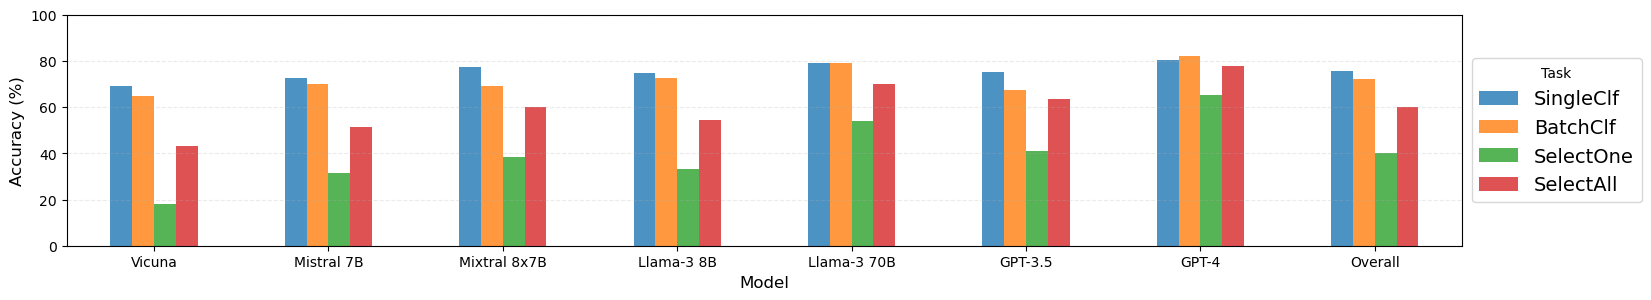

In [18]:
import matplotlib.pyplot as plt

# make a bar plot for all_overall_results_df, single_overall_results_df, and pair_overall_results_df
# and make sure each plot stack on the top of the other and mark the accuracy for each task

fig, ax = plt.subplots(figsize=(18, 3))
# single_overall_results_df[tasks].plot(kind='bar', ax=ax, alpha=0.4)
all_overall_results_df[tasks].plot(kind='bar', ax=ax, alpha=0.8)
# pair_overall_results_df[tasks].plot(kind='bar', ax=ax, alpha=0.4)
plt.ylabel("Accuracy (%)", fontsize=12)
plt.xlabel("Model", fontsize=12)
plt.xticks(rotation=0)

# make dummy legends where the actual legends should be to make the plot look better
import matplotlib.patches as mpatches

single_patch = mpatches.Patch(color='tab:blue', label='Single Clf')
batch_patch = mpatches.Patch(color='tab:orange', label='Batch Clf')
index_one_patch = mpatches.Patch(color='tab:green', label='Index Select One Cat')
index_all_patch = mpatches.Patch(color='tab:red', label='Index Select All Cat')
# plt.legend(handles=[single_patch, batch_patch, index_one_patch, index_all_patch], loc='center left', bbox_to_anchor=(1, 0.5))

# make the legend contain gradient colors for the three overall results: single, pair, and all
# overall_patch = mpatches.Patch(color='gray', label='Single-text Benchmarks', alpha=0.4)
# single_overall_patch = mpatches.Patch(color='gray', label='All Benchmarks', alpha=0.7)
# pair_overall_patch = mpatches.Patch(color='gray', label='Text-pair Benchmarks', alpha=1)
# plt.legend(handles=[single_patch, batch_patch, index_one_patch, index_all_patch, 
#                     overall_patch, single_overall_patch, pair_overall_patch], 
#                     loc='center left', bbox_to_anchor=(1, 0.5))

plt.legend(title="Task",loc='center left', bbox_to_anchor=(1, 0.5), fontsize=14)
# plt.legend(loc='upper center', bbox_to_anchor=(-2.65, -0.35), fancybox=False, shadow=False, ncol=8)

plt.grid(axis='y', linestyle='--', alpha=0.25)
plt.ylim(0, 100)
plt.savefig("plots/average_accuracy_on_the_4_tasks_for_the_7_llms.png", bbox_inches='tight', dpi=300)
plt.show()

### Constrasting task pairs

In [40]:
main_results = []
cols = ["benchmark", "model", "task", "taskSize", "accuracy"]
tasks = ["BatchClf", "SelectOne", "SelectAll"]

for benchmark in benchmarks:
    for model in prp_df_adjusted.model.unique():
        sub = prp_df_adjusted.copy()[(prp_df_adjusted.benchmark == benchmark) & (prp_df_adjusted.model == model)]

        for task in tasks:
            subsub = sub.copy()[sub.task == task]
            for taskSize in sorted(subsub.taskSize.unique()):
                subsubsub = subsub.copy()[subsub.taskSize == taskSize]
                acc = subsubsub["performance"].mean()
                main_results.append([benchmark, model, task, taskSize, acc])

main_results_df = pd.DataFrame(main_results, columns=cols)
main_results_df_pv = main_results_df.pivot(index=["benchmark", "model", "taskSize"], columns="task", values="accuracy")
main_results_df_pv = main_results_df_pv.loc[benchmarks]
main_results_df_pv = main_results_df_pv.round(3)
main_results_df_pv = main_results_df_pv * 100
main_results_df_pv = main_results_df_pv.astype(float)
main_results_df_pv[tasks]

task                        BatchClf  SelectOne  SelectAll
benchmark model   taskSize                                
SST-2     GPT-3.5 5             95.2       75.2       83.8
                  10            95.0       71.9       83.1
                  20            93.4       69.0       84.2
                  50            74.0       53.6       82.1
                  100           71.6       48.4       76.5
...                              ...        ...        ...
WiC       Vicuna  3             30.0       27.3       45.0
                  5             52.2       26.6       53.2
                  10            53.4       34.5       48.8
                  20            51.6       24.0       43.8
                  50            49.9       30.0       28.2

[209 rows x 3 columns]

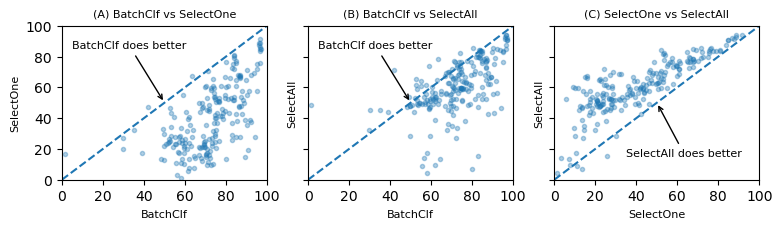

In [41]:
import matplotlib.pyplot as plt

ax_ix = 0
fig, axs = plt.subplots(1, 3, figsize=(9, 2), sharey=True)
multi_question_tasks = ["BatchClf", "SelectOne", "SelectAll"]
# task_renamer = {"BatchClf": "BatchClf", "Index Select One Cat": "OneSelect", "Index Select All Cat": "AllSelect"}
indices = ["(A)", "(B)", "(C)"]

for i in range(len(multi_question_tasks)):
    t1 = multi_question_tasks[i]
    for j in range(i+1, len(multi_question_tasks)):
        t2 = multi_question_tasks[j]
        p1 = main_results_df_pv[t1]
        p2 = main_results_df_pv[t2]

        ax = axs[ax_ix]
        ax.scatter(p1, p2, alpha=0.35, marker=".")
        ax.plot([0, 100], [0, 100], linestyle='--')
        ax.set_xlabel(t1, fontsize=8)
        ax.set_ylabel(t2, fontsize=8)
        ax.set_xticks(range(0, 101, 20))
        ax.set_yticks(range(0, 101, 20))
        ax.set_title(f"{indices[ax_ix]} {t1} vs {t2}", fontsize=8)
        # ax.grid(alpha=0.25)
        ax.set_xlim(0, 100)
        ax.set_ylim(0, 100)
        ax_ix += 1

        if ax_ix != 3:
            ax.annotate('BatchClf does better', xy=(50, 50), xytext=(5, 85),
                arrowprops=dict(arrowstyle="->", facecolor='black'), fontsize=8)
        else:
            ax.annotate('SelectAll does better', xy=(50, 50), xytext=(35, 15),
                arrowprops=dict(arrowstyle="->", facecolor='black'), fontsize=8)

# plt.savefig("plots/pariWiseAccAmongThreeTaskPairs.png", bbox_inches='tight', dpi=300)

In [67]:
gaps = []
cols = ["BatchClf vs SelectOne", "BatchClf vs SelectAll", "SelectOne vs SelectAll"]
multi_question_tasks = ["BatchClf", "SelectOne", "SelectAll"]

for i in range(len(multi_question_tasks)):
    t1 = multi_question_tasks[i]
    for j in range(i+1, len(multi_question_tasks)):
        t2 = multi_question_tasks[j]
        gaps.append(main_results_df_pv[t1] - main_results_df_pv[t2])

In [68]:
gaps_df = pd.DataFrame(zip(*gaps), columns=cols)
stats = gaps_df.describe().loc[["mean", "std"]].round(1)
stats.index = ["MeanDif", "Std"]
stats

,BatchClf vs SelectOne,BatchClf vs SelectAll,SelectOne vs SelectAll
MeanDif,32.0,12.1,-19.9
Std,16.9,15.3,12.0


In [69]:
from scipy.stats import normaltest

for col in ["BatchClf", "SelectOne", "SelectAll"]:
    print(col, normaltest(main_results_df_pv[col]))

BatchClf NormaltestResult(statistic=31.947201628894568, pvalue=1.1554557287654462e-07)
SelectOne NormaltestResult(statistic=17.4302192388227, pvalue=0.0001640876831912266)
SelectAll NormaltestResult(statistic=17.24919165092667, pvalue=0.000179632793756854)


In [70]:
from scipy.stats import mannwhitneyu
from numpy import std, mean, sqrt

def cohen_d(x,y):
    nx = len(x)
    ny = len(y)
    dof = nx + ny - 2
    return (mean(x) - mean(y)) / sqrt(((nx-1)*std(x, ddof=1) ** 2 + (ny-1)*std(y, ddof=1) ** 2) / dof)

ps = []
ds = []
stats = gaps_df.describe().loc[["mean", "std"]].round(1)
stats.index = ["Mean Acc Dif", "Std Dev"]


for i in range(len(multi_question_tasks)):
    t1 = multi_question_tasks[i]

    for j in range(i+1, len(multi_question_tasks)):
        t2 = multi_question_tasks[j]
        p1 = main_results_df_pv[t1]
        p2 = main_results_df_pv[t2]
        ps.append(mannwhitneyu(p1, p2).pvalue)
        ds.append(cohen_d(p1, p2))

# stats.loc["p value"] = ps
stats.loc["Cohen's d"] = ds
print(stats.round(1).to_latex())

\begin{tabular}{lrrr}
\toprule
{} &  BatchClf vs SelectOne &  BatchClf vs SelectAll &  SelectOne vs SelectAll \\
\midrule
Mean Acc Dif &                   32.0 &                   12.1 &                   -19.9 \\
Std Dev      &                   16.9 &                   15.3 &                    12.0 \\
Cohen's d    &                    1.8 &                    0.8 &                    -1.0 \\
\bottomrule
\end{tabular}



/var/folders/w9/d_nplhzj4qx35xxlgljgdtjh0000gn/T/ipykernel_1126/2851525374.py:28: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(stats.round(1).to_latex())


In [71]:
max(ps) < 1e-13

True

## Main results across the four tasks with taskSize

In [72]:
main_results = []
cols = ["benchmark", "task", "taskSize", "accuracy"]
tasks = ["SingleClf", "BatchClf", "SelectOne", "SelectAll"]
benchmarks = ["SST-2", "CoLA", "AGNews", "MRPC", "SNLI", "WiC"]
# names = []
# for bs, name in zip([["SST-2", "CoLA", "AGNews"], ["MRPC", "SNLI", "WiC"]], ["single-text", "text-pair"]):
#     for task in tasks:
#         sub = prp_df_adjusted.copy()[(prp_df_adjusted.task == task) & 
#                                      (prp_df_adjusted.benchmark.isin(bs))]
#         for taskSize in sorted(sub.taskSize.unique()):
#             subsub = sub.copy()[sub.taskSize == taskSize]
#             acc = subsub["performance"].mean()
#             name = "+".join(bs)
#             names.append(f"{name}")
#             main_results.append([f"{name}", task, taskSize, acc])

for benchmark in benchmarks:
    sub = prp_df_adjusted.copy()[prp_df_adjusted.benchmark == benchmark]
    for task in tasks:
        subsub = sub.copy()[sub.task == task]
        for taskSize in sorted(subsub.taskSize.unique()):
            subsubsub = subsub.copy()[subsub.taskSize == taskSize]
            acc = subsubsub["performance"].mean()
            main_results.append([benchmark, task, taskSize, acc])

# benchmarks = names[:1] + names[-1:] + benchmarks[:3] + benchmarks[3:]
main_results_df = pd.DataFrame(main_results, columns=cols)
main_results_df_pv = main_results_df.pivot(index=["benchmark", "taskSize"], columns="task", values="accuracy")
main_results_df_pv = main_results_df_pv.loc[benchmarks]
main_results_df_pv = main_results_df_pv.round(3)
main_results_df_pv = main_results_df_pv * 100
main_results_df_pv = main_results_df_pv.astype(float)
main_results_df_pv[tasks]

task                SingleClf  BatchClf  SelectOne  SelectAll
benchmark taskSize                                           
SST-2     1              91.4       NaN        NaN        NaN
          5               NaN      91.0       59.7       79.1
          10              NaN      89.8       68.6       81.2
          20              NaN      87.7       66.2       79.2
          50              NaN      89.3       55.1       71.5
          100             NaN      89.3       47.0       65.6
CoLA      1              82.4       NaN        NaN        NaN
          5               NaN      79.0       54.7       70.0
          10              NaN      79.5       58.0       72.0
          20              NaN      77.0       54.4       71.4
          50              NaN      75.6       48.2       64.1
          100             NaN      71.9       43.8       61.0
AGNews    1              81.1       NaN        NaN        NaN
          5               NaN      79.3       43.5       60.5
          10              NaN      79.9       48.7       62.4
          20              NaN      77.2       44.2       57.3
          50              NaN      73.5       34.8       42.3
          100             NaN      71.5       29.7       35.2
MRPC      1              75.5       NaN        NaN        NaN
          3               NaN      68.4       34.0       63.2
          5               NaN      69.4       39.1       64.1
          10              NaN      67.6       37.7       66.2
          20              NaN      66.6       34.5       62.6
          50              NaN      58.3       30.3       57.9
SNLI      1              57.8       NaN        NaN        NaN
          3               NaN      67.9       21.4       53.4
          5               NaN      68.9       24.2       54.5
          10              NaN      69.6       27.6       56.3
          20              NaN      68.4       25.8       49.7
          50              NaN      65.6       22.5       43.3
WiC       1              64.9       NaN        NaN        NaN
          3               NaN      54.6       30.6       53.9
          5               NaN      59.5       32.4       53.7
          10              NaN      59.2       32.7       52.7
          20              NaN      57.6       28.3       51.0
          50              NaN      55.4       28.8       47.1

In [73]:
mean = lambda ls: sum(ls) / len(ls)
models = ["Vicuna", "Mistral 7B", "Mixtral 8x7B", 
          "Llama-3 8B", "Llama-3 70B", "GPT-3.5", "GPT-4"]

rs = []
cols = ["> 90% SingleClf", "> 80% SingleClf", "> 75% SingleClf"]
difs_90_all = []
difs_80_all = []
difs_75_all = []

for model in models:
    difs_90 = []
    difs_80 = []
    disf_75 = []

    for benchmark in benchmarks:
        sub = prp_df_adjusted.copy()[(prp_df_adjusted.benchmark == benchmark) & 
                                    (prp_df_adjusted.model == model)]
        sc = sub.copy()[sub.task == "SingleClf"].performance.item()
        
        for taskSize in sorted(sub.taskSize.unique())[1:]:
            bc = sub.copy()[(sub.taskSize == taskSize) & (sub.task == "BatchClf")].performance.item()        
            difs_90.append(bc > sc*0.9)
            difs_80.append(bc > sc*0.8)
            disf_75.append(bc > sc*0.75)

            difs_90_all.append(bc > sc*0.9)
            difs_80_all.append(bc > sc*0.8)
            difs_75_all.append(bc > sc*0.75)
    
    rs.append([mean(difs_90), mean(difs_80), mean(disf_75)])

mean = lambda ls: sum(ls) / len(ls)
rs = [[mean(difs_90_all), mean(difs_80_all), mean(difs_75_all)]] + rs

rs_df = pd.DataFrame(rs, columns=cols).round(3)*100
rs_df.index = ["Overall"] + models
# rs_df.drop(columns=["> 70% SingleClf"], inplace=True)
rs_df

,> 90% SingleClf,> 80% SingleClf,> 75% SingleClf
Overall,75.6,90.4,95.7
Vicuna,79.3,93.1,93.1
Mistral 7B,76.7,83.3,100.0
Mixtral 8x7B,63.3,83.3,86.7
Llama-3 8B,73.3,90.0,100.0
Llama-3 70B,80.0,100.0,100.0
GPT-3.5,56.7,83.3,90.0
GPT-4,100.0,100.0,100.0


In [29]:
print(rs_df.to_latex())

\begin{tabular}{lrrr}
\toprule
{} &  > 90\% SingleClf &  > 80\% SingleClf &  > 75\% SingleClf \\
\midrule
Overall      &             75.6 &             90.4 &             95.7 \\
Vicuna 13B   &             79.3 &             93.1 &             93.1 \\
Mistral 7B   &             76.7 &             83.3 &            100.0 \\
Mixtral 8x7B &             63.3 &             83.3 &             86.7 \\
Llama-3 8B   &             73.3 &             90.0 &            100.0 \\
Llama-3 70B  &             80.0 &            100.0 &            100.0 \\
GPT-3.5      &             56.7 &             83.3 &             90.0 \\
GPT-4        &            100.0 &            100.0 &            100.0 \\
\bottomrule
\end{tabular}



/var/folders/w9/d_nplhzj4qx35xxlgljgdtjh0000gn/T/ipykernel_2541/2912988865.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(rs_df.to_latex())


In [74]:
difs = []
cols = ["model", "taskSize", "dif", "%"]

for model in models:
    sub = prp_df_adjusted.copy()[(prp_df_adjusted.model == model) & 
                                 (prp_df_adjusted.benchmark == "SNLI")]
    sc = sub.copy()[sub.task == "SingleClf"].performance.item()

    for taskSize in sorted(sub.taskSize.unique())[1:]:
        bc = sub.copy()[(sub.taskSize == taskSize) & (sub.task == "BatchClf")].performance.item()
        difs.append([model, taskSize, bc - sc, (bc-sc) / sc])

difs_df = pd.DataFrame(difs, columns=cols)
difs_df

,model,taskSize,dif,%
0,Vicuna,3,0.090333,0.190980
1,Vicuna,5,0.107000,0.226216
2,Vicuna,10,0.120000,0.253700
3,Vicuna,20,0.108000,0.228330
4,Vicuna,50,0.084200,0.178013
5,Mistral 7B,3,0.160667,0.299751
6,Mistral 7B,5,0.138000,0.257463
7,Mistral 7B,10,0.155000,0.289179
8,Mistral 7B,20,0.129500,0.241604
9,Mistral 7B,50,0.084200,0.157090


In [75]:
difs_df[difs_df.model != "GPT-3.5"]["dif"].round(3).describe() * 100

count    3000.000000
mean       12.893333
std         3.901895
min         5.900000
25%         9.100000
50%        13.950000
75%        15.575000
max        19.200000
Name: dif, dtype: float64

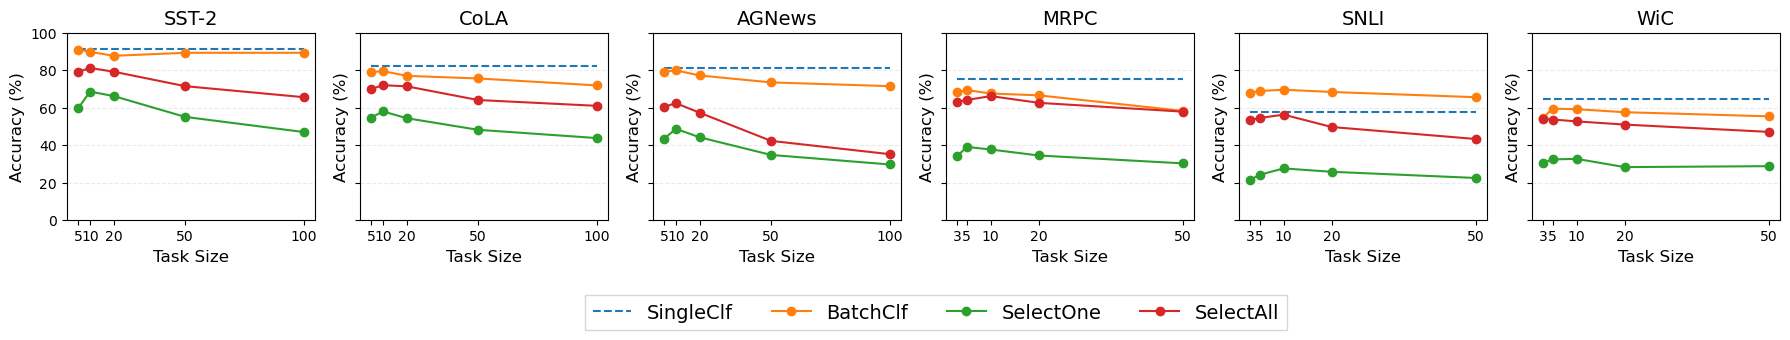

In [78]:
# make a 1x6 grid plots, where each panel is a benchmark, with the taskSize on the x-axis and accuracy on the y-axis.

task2color = {"SingleClf": "tab:blue", "BatchClf": "tab:orange", 
              "SelectOne": "tab:green", "SelectAll": "tab:red"}

fig, axs = plt.subplots(1, len(benchmarks), figsize=(18, 3), sharey=True)
for i, benchmark in enumerate(benchmarks):
    sub = main_results_df[main_results_df.benchmark == benchmark]
    taskSizes = sorted(sub.taskSize.unique())[1:]
    for task in tasks:
        subsub = sub[sub.task == task]

        if task == "SingleClf":
            acc = subsub.accuracy
            axs[i].plot(taskSizes, [round(acc, 3) * 100] * len(taskSizes), label=task, linestyle="--", color=task2color[task])
            # axs[i].plot(taskSizes, [round(acc * 0.90, 3) * 100] * len(taskSizes), label=f"90% {task} Acc", 
            #             linestyle="--", color=task2color[task], alpha=0.75)
            # axs[i].plot(taskSizes, [round(acc * 0.80, 3) * 100] * len(taskSizes), label=f"80% {task} Acc", 
            #             linestyle="--", color=task2color[task], alpha=0.5)
            
            # axs[i].plot(taskSizes, [round(acc * 0.75, 3) * 100] * len(taskSizes), label=f"75% {task} Acc", 
            #             linestyle="--", color=task2color[task], alpha=0.22)

            # if "+" in benchmark:
            #     random_baseline = prp_df[(prp_df.model == "Random Baseline") & (prp_df.benchmark.isin(benchmark.split("+")))].performance.mean()
            # else:
            #     random_baseline = prp_df[(prp_df.model == "Random Baseline") & (prp_df.benchmark == benchmark)].performance.mean()
            # axs[i].plot(taskSizes, [round(random_baseline, 3) * 100]*5, label="Random Baseline", linestyle="--", color="tab:gray")
        else:
            accs = []
            for taskSize in taskSizes:
                acc = subsub[subsub.taskSize == taskSize].accuracy
                accs.append(round(acc, 3) * 100)
                
            axs[i].plot(taskSizes, accs, label=task, marker='o', linestyle="-", color=task2color[task])
        
        axs[i].set_title(benchmark, fontsize=14)
        axs[i].set_xlabel("Task Size", fontsize=12)
        axs[i].set_xticks(taskSizes)
        axs[i].set_ylabel("Accuracy (%)", fontsize=12)
        axs[i].grid(axis='y', linestyle='--', alpha=0.25)
        # axs[i].legend(title="Task", loc='center left', bbox_to_anchor=(1, 0.5))
        axs[i].set_ylim(0, 100)

# plt.suptitle("Average accuracy of the 7 LLMs on different tasks and task sizes")
plt.tight_layout(rect=[0, 0, 1, 0.95])
# plt.legend(title="Task", loc='center left', bbox_to_anchor=(1, 0.5))
plt.legend(loc='upper center', bbox_to_anchor=(-2.4, -0.35), fontsize=14, fancybox=False, shadow=False, ncol=8)
plt.savefig("plots/average_accuracy_of_the_7_llms_on_the_4_tasks_across_task_sizes.png", bbox_inches='tight', dpi=300)
plt.show()

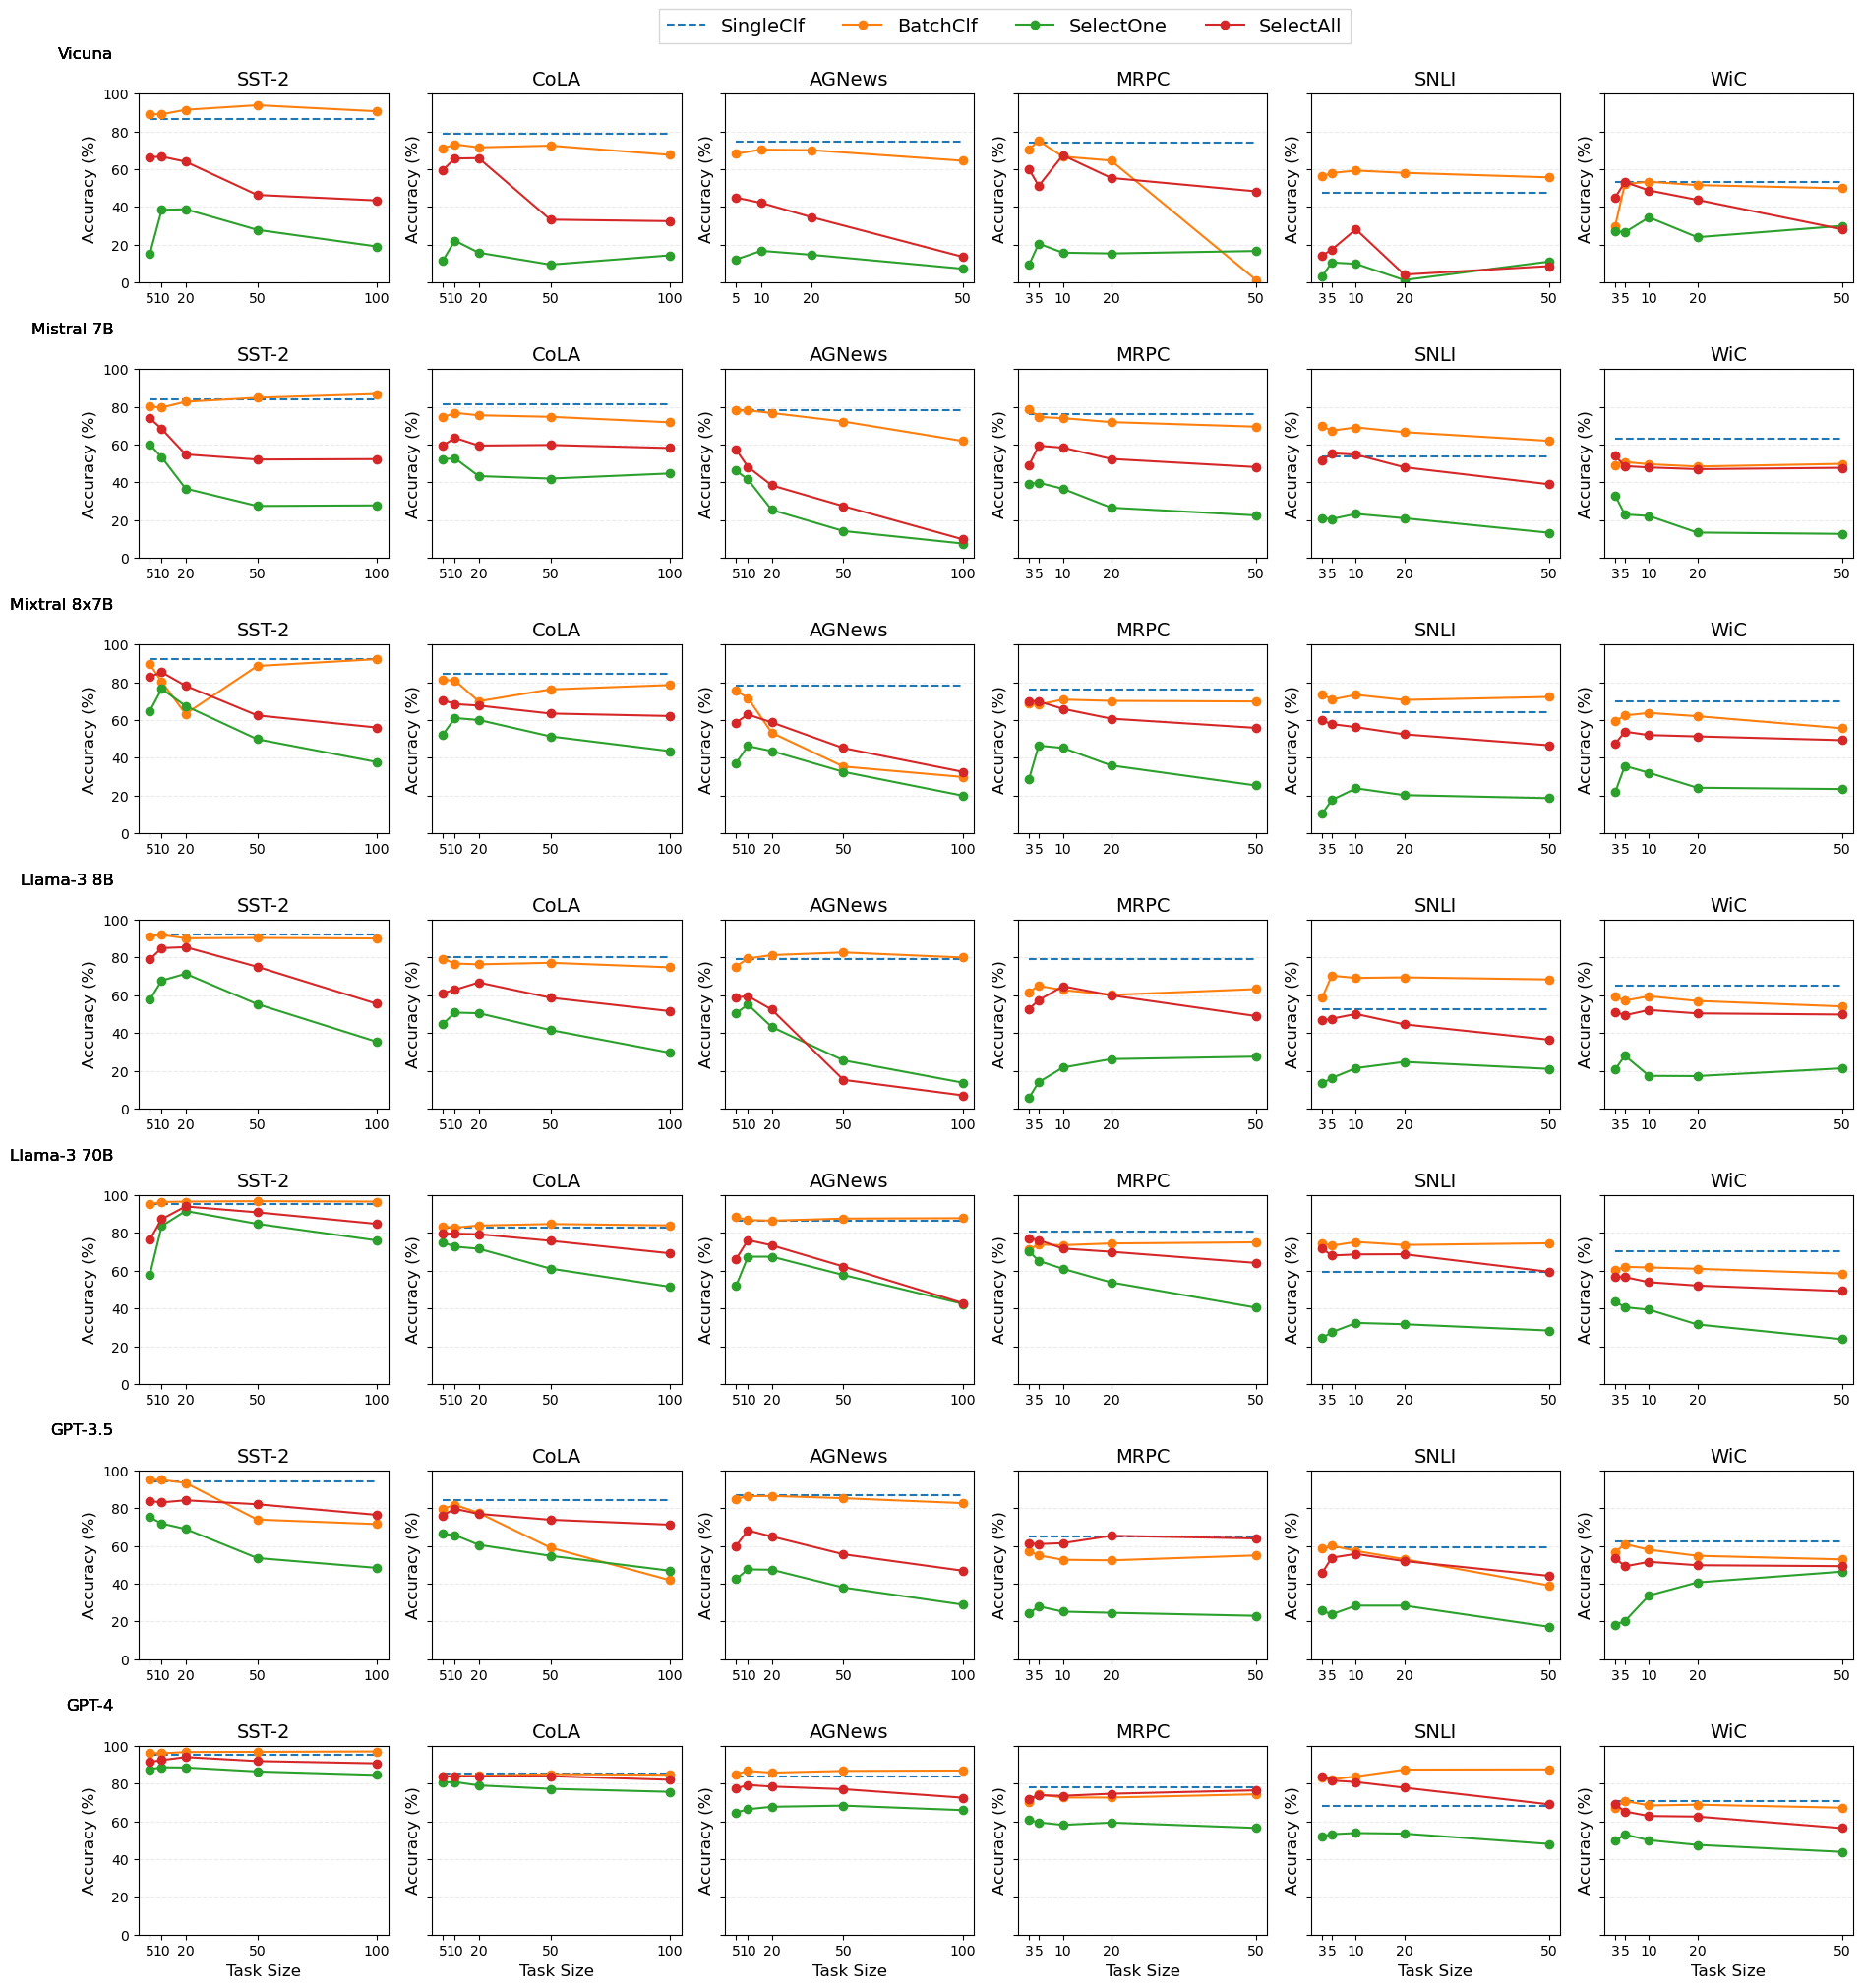

In [80]:
# make a 1x6 grid plots, where each panel is a benchmark, with the taskSize on the x-axis and accuracy on the y-axis.

task2color = {"SingleClf": "tab:blue", "BatchClf": "tab:orange", "SelectOne": "tab:green", "SelectAll": "tab:red"}

fig, axs = plt.subplots(len(models), 6, figsize=(19, 21), sharey=True)
prp_df_adjusted["accuracy"] = prp_df_adjusted.performance
benchmarks = ["SST-2", "CoLA", "AGNews", "MRPC", "SNLI", "WiC"]

for j, model in enumerate(models):
    for i, benchmark in enumerate(benchmarks):
        sub = prp_df_adjusted[(prp_df_adjusted.benchmark == benchmark) & (prp_df_adjusted.model == model)]
        taskSizes = sorted(sub.taskSize.unique())[1:]
        ax = axs[j][i]
        for task in tasks:
            subsub = sub[sub.task == task]

            if task == "SingleClf":
                acc = subsub.accuracy
                ax.plot(taskSizes, [round(acc, 3) * 100]*len(taskSizes), label=task, linestyle="--", color=task2color[task])
                # ax.plot(taskSizes, [round(acc * 0.90, 3) * 100] * len(taskSizes), label=f"90% {task} Acc", 
                #         linestyle="--", color=task2color[task], alpha=0.75)
                # ax.plot(taskSizes, [round(acc * 0.80, 3) * 100] * len(taskSizes), label=f"80% {task} Acc", 
                #         linestyle="--", color=task2color[task], alpha=0.5)
                
                # ax.plot(taskSizes, [round(acc * 0.75, 3) * 100] * len(taskSizes), label=f"75% {task} Acc", 
                #         linestyle="--", color=task2color[task], alpha=0.25)

                # random_baseline = prp_df[(prp_df.model == "Random Baseline") & (prp_df.benchmark == benchmark)].performance.mean()
                # ax.plot(taskSizes, [round(random_baseline, 3) * 100]*len(taskSizes), label="Random Baseline", linestyle="--", color="tab:gray")
            else:
                accs = []
                for taskSize in taskSizes:
                    acc = subsub[subsub.taskSize == taskSize].accuracy
                    accs.append(round(acc, 3) * 100)
                    
                ax.plot(taskSizes, accs, label=task, marker='o', linestyle="-", color=task2color[task])
            
            ax.set_title(benchmark, fontsize=14)
            # if j == 0:
            #    ax.set_title(benchmark)

            if i == 0:
                ax.text(-0.1, 1.25, model, transform=ax.transAxes, 
                        fontsize=12, va='top', ha='right')

            if j == len(models) - 1:
                ax.set_xlabel("Task Size", fontsize=12)
            ax.set_xticks(taskSizes)
            ax.set_ylabel("Accuracy (%)", fontsize=12)
            ax.set_yticks(np.arange(0, 101, 20))
            ax.grid(axis='y', linestyle='--', alpha=0.25)
            # axs[i].legend(title="Task", loc='center left', bbox_to_anchor=(1, 0.5))
            ax.set_ylim(0, 100)

            # if j == 3 and i == 5:
            #     ax.legend(title="Task", loc='center left', bbox_to_anchor=(1.05, 0.5))

# plt.suptitle("Average accuracy of the 7 LLMs on different tasks and task sizes")
plt.tight_layout(rect=[0, 0, 1, 0.95])
# plt.legend(title="Task", loc='center left', bbox_to_anchor=(1, 0.5))
plt.legend(loc='upper center', bbox_to_anchor=(-2.4, 10.25), fontsize=14, fancybox=False, shadow=False, ncol=7)

plt.savefig("plots/full_results.png", bbox_inches='tight', dpi=300)
plt.show()

### SelectOne versus SelectAll

In [20]:
evaled_df.columns

Index(['benchmark', 'taskIndex', 'prompt', 'answer', 'targetLabel', 'task',
       '#shot', 'CoT', 'taskSize', 'model', 'completion', 'parsed',
       'perTaskAccu', 'jaccardSim', '#dif', '#contradictions',
       '#nonExcludedMiddles', 'prompt_tokens', 'completion_tokens'],
      dtype='object')

In [21]:
evaled_df.task.unique()

array(['single_clf', 'batch_clf', 'index_selection_one_cat_a_time',
       'index_selection_all_cat_at_once',
       'index_selection_all_cat_at_once_adjusted',
       'index_selection_one_cat_a_time_json'], dtype=object)

In [22]:
selection_tasks = ["index_selection_all_cat_at_once", 
                   "index_selection_all_cat_at_once_adjusted", 
                   "index_selection_one_cat_a_time_json"]

In [23]:
model_renamer = {"meta-llama/Llama-3-70b-chat-hf": "Llama-3 70B", "mistralai/Mixtral-8x7B-Instruct-v0.1": "Mixtral 8x7B", 
                    "gpt-3.5-turbo-0125": "GPT-3.5", "meta-llama/Llama-3-8b-chat-hf": "Llama-3 8B", 
                    "mistralai/Mistral-7B-Instruct-v0.2": "Mistral 7B", "gpt-4-turbo-2024-04-09": "GPT-4", 
                    "lmsys/vicuna-13b-v1.5": "Vicuna", "random baseline": "Random Baseline"}

In [24]:
# cols = ["model", "task"]

selection_df = evaled_df.copy()[evaled_df.task.isin(selection_tasks)]
selection_df.model = selection_df.model.map(model_renamer)

selection_df = selection_df.copy()[~((selection_df.model == "Vicuna") & 
                                     (selection_df.benchmark == "AGNews") & 
                                     (selection_df.taskSize == 100))]
selection_df.task = selection_df.apply(lambda row: "index_selection_all_cat_at_once_adjusted" 
                                       if row.benchmark in ["CoLA", "AGNews"] and 
                                       row.task == "index_selection_all_cat_at_once" 
                                       else row.task, axis=1)
selection_df = selection_df.copy()[selection_df.task != "index_selection_all_cat_at_once"]

selection_df.task = selection_df.task.map(task_renamer)
selection_df.model.unique(), selection_df.task.unique()

(array(['Llama-3 70B', 'Mixtral 8x7B', 'GPT-3.5', 'Llama-3 8B',
        'Mistral 7B', 'GPT-4', 'Vicuna'], dtype=object),
 array(['SelectAll', 'SelectOne'], dtype=object))

In [25]:
selection_df.taskSize.unique()

array([  5,  10,  20,  50, 100,   3])

In [26]:
select_tasks_comp = []
cols = ["benchmark", "model", "task", "taskSize", 
        "#contradictions", "#nonExcludedMiddles", "perTaskAccu"]

for benchmark in benchmarks:
    for model in models:
        sub = selection_df.copy()[(selection_df.benchmark == benchmark) & (selection_df.model == model)]
        for task in sorted(selection_df.task.unique()):
            subsub = sub.copy()[sub.task == task]
            for taskSize in sorted(subsub.taskSize.unique()):
                subsubsub = subsub.copy()[subsub.taskSize == taskSize]
                contradictions = subsubsub["#contradictions"].mean()
                nonExcludedMiddles = subsubsub["#nonExcludedMiddles"].mean()
                perTaskAccu = subsubsub["perTaskAccu"].mean()
                select_tasks_comp.append([benchmark, model, task, taskSize, contradictions, nonExcludedMiddles, perTaskAccu])

select_tasks_comp_df = pd.DataFrame(select_tasks_comp, columns=cols)
select_tasks_comp_df_pv = select_tasks_comp_df.pivot(index=["benchmark", "model", "taskSize"], columns="task", values=["#contradictions", "#nonExcludedMiddles", "perTaskAccu"])
select_tasks_comp_df_pv = select_tasks_comp_df_pv.loc[benchmarks]
select_tasks_comp_df_pv = select_tasks_comp_df_pv.round(3)
select_tasks_comp_df_pv = select_tasks_comp_df_pv.astype(float)
select_tasks_comp_df_pv

#contradictions           #nonExcludedMiddles  \
task                             SelectAll SelectOne           SelectAll   
benchmark model   taskSize                                                 
SST-2     GPT-3.5 5                   0.00      0.04                0.47   
                  10                  0.00      0.02                1.28   
                  20                  0.00      0.02                2.33   
                  50                  0.01      0.23                5.47   
                  100                 0.03      1.23               11.28   
...                                    ...       ...                 ...   
WiC       Vicuna  3                   0.02      0.04                0.26   
                  5                   0.00      0.27                0.00   
                  10                  0.22      0.14                0.11   
                  20                  2.29      7.95                0.04   
                  50                 21.38      9.21                0.09   

                                     perTaskAccu            
task                       SelectOne   SelectAll SelectOne  
benchmark model   taskSize                                  
SST-2     GPT-3.5 5             1.08       0.838     0.752  
                  10            2.64       0.831     0.719  
                  20            6.04       0.842     0.690  
                  50           22.21       0.821     0.536  
                  100          47.19       0.765     0.484  
...                              ...         ...       ...  
WiC       Vicuna  3             1.36       0.450     0.273  
                  5             2.00       0.532     0.266  
                  10            2.80       0.488     0.345  
                  20            2.32       0.438     0.240  
                  50            9.93       0.282     0.300  

[209 rows x 6 columns]

In [27]:
models = ['Vicuna',
 'Mistral 7B',
 'Mixtral 8x7B',
 'Llama-3 8B',
 'Llama-3 70B',
 'GPT-3.5',
 'GPT-4']

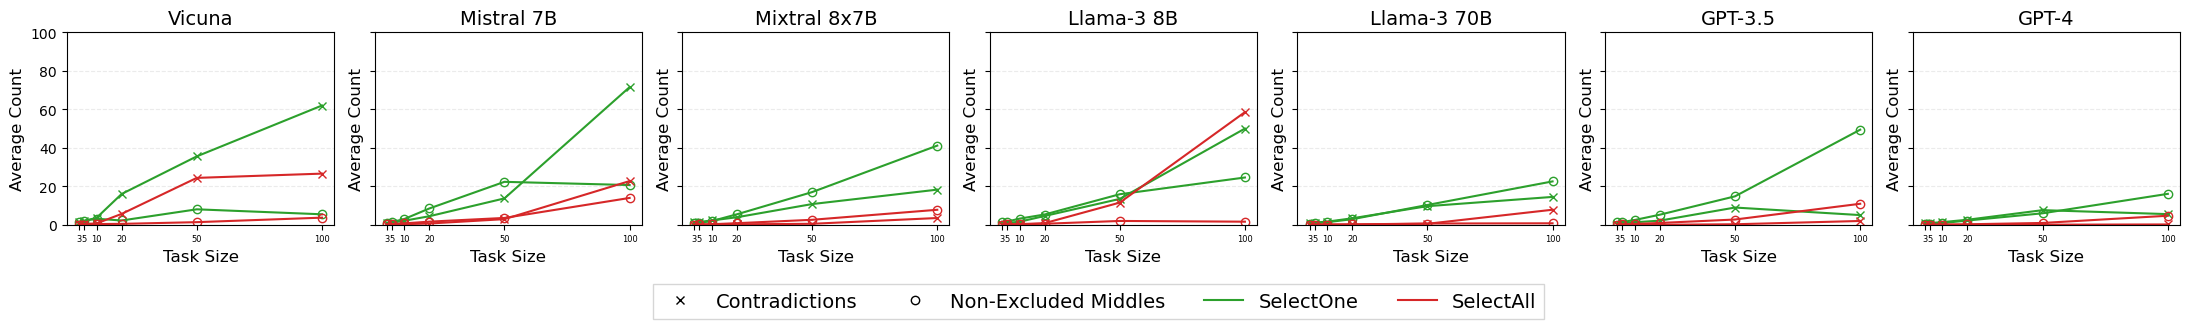

In [29]:
# add a twin y-axis to the plot to show the accuracy of the two tasks with the same model and taskSize in lower alpha


fig, axs = plt.subplots(1, 7, figsize=(22, 3), sharey=True)
metric2marker = {"#contradictions": "x", "#nonExcludedMiddles": "o"}
models = ['Vicuna', 'Mistral 7B', 'Mixtral 8x7B', 'Llama-3 8B', 
          'Llama-3 70B', 'GPT-3.5', 'GPT-4']
task2color = {"SingleClf": "tab:blue", "BatchClf": "tab:orange",
                "SelectOne": "tab:green", "SelectAll": "tab:red"}

for i, model in enumerate(models):
    sub = selection_df.copy()[selection_df.model == model]
    taskSizes = sorted(sub.taskSize.unique())
    ax = axs[i]

    for task in tasks:
        subsub = sub[sub.task == task]
        for metric in ["#contradictions", "#nonExcludedMiddles"]:
            metric_values = []
            for taskSize in taskSizes:
                metric_value = subsub[subsub.taskSize == taskSize][metric].mean()
                metric_values.append(metric_value)
            
            ax.plot(taskSizes, metric_values, marker=metric2marker[metric], 
                        linestyle="-", color=task2color[task], mfc='none')
            
        # ax_twin = ax.twinx()
        # accs = []
        # for taskSize in taskSizes:
        #     acc = subsub[subsub.taskSize == taskSize]["perTaskAccu"].mean()
        #     accs.append(round(acc, 3) * 100)

        # ax_twin.plot(taskSizes, accs, marker='.', linestyle="--", color=task2color[task], alpha=0.35)
        # ax_twin.set_ylim(0, 100)

        # ax_twin.set_ylabel("Accuracy (%)")
        
        ax.set_title(model, fontsize=14)
        ax.set_xlabel("Task Size", fontsize=12)
        ax.set_xticks(taskSizes)
        ax.set_xticklabels(ax.get_xticks(), fontsize=6)

        ax.set_ylabel("Average Count", fontsize=12)
        ax.grid(axis='y', linestyle='--', alpha=0.25)
        ax.set_ylim(0, 100)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.plot([], [], 'x', color='black', label='Contradictions')
plt.plot([], [], 'o', color='black', label='Non-Excluded Middles', mfc='none')
# plt.plot([], [], linestyle='--', color='black', alpha=0.35, label='Accuracy')
plt.plot([], [], 'tab:green', label='SelectOne')
plt.plot([], [], 'tab:red', label='SelectAll')

plt.legend(loc='center left', bbox_to_anchor=(-4.75, -0.4), fontsize=14, fancybox=False, shadow=False, ncol=5)
plt.savefig("plots/selection_tasks_comparison.png", bbox_inches='tight', dpi=300)
plt.show()

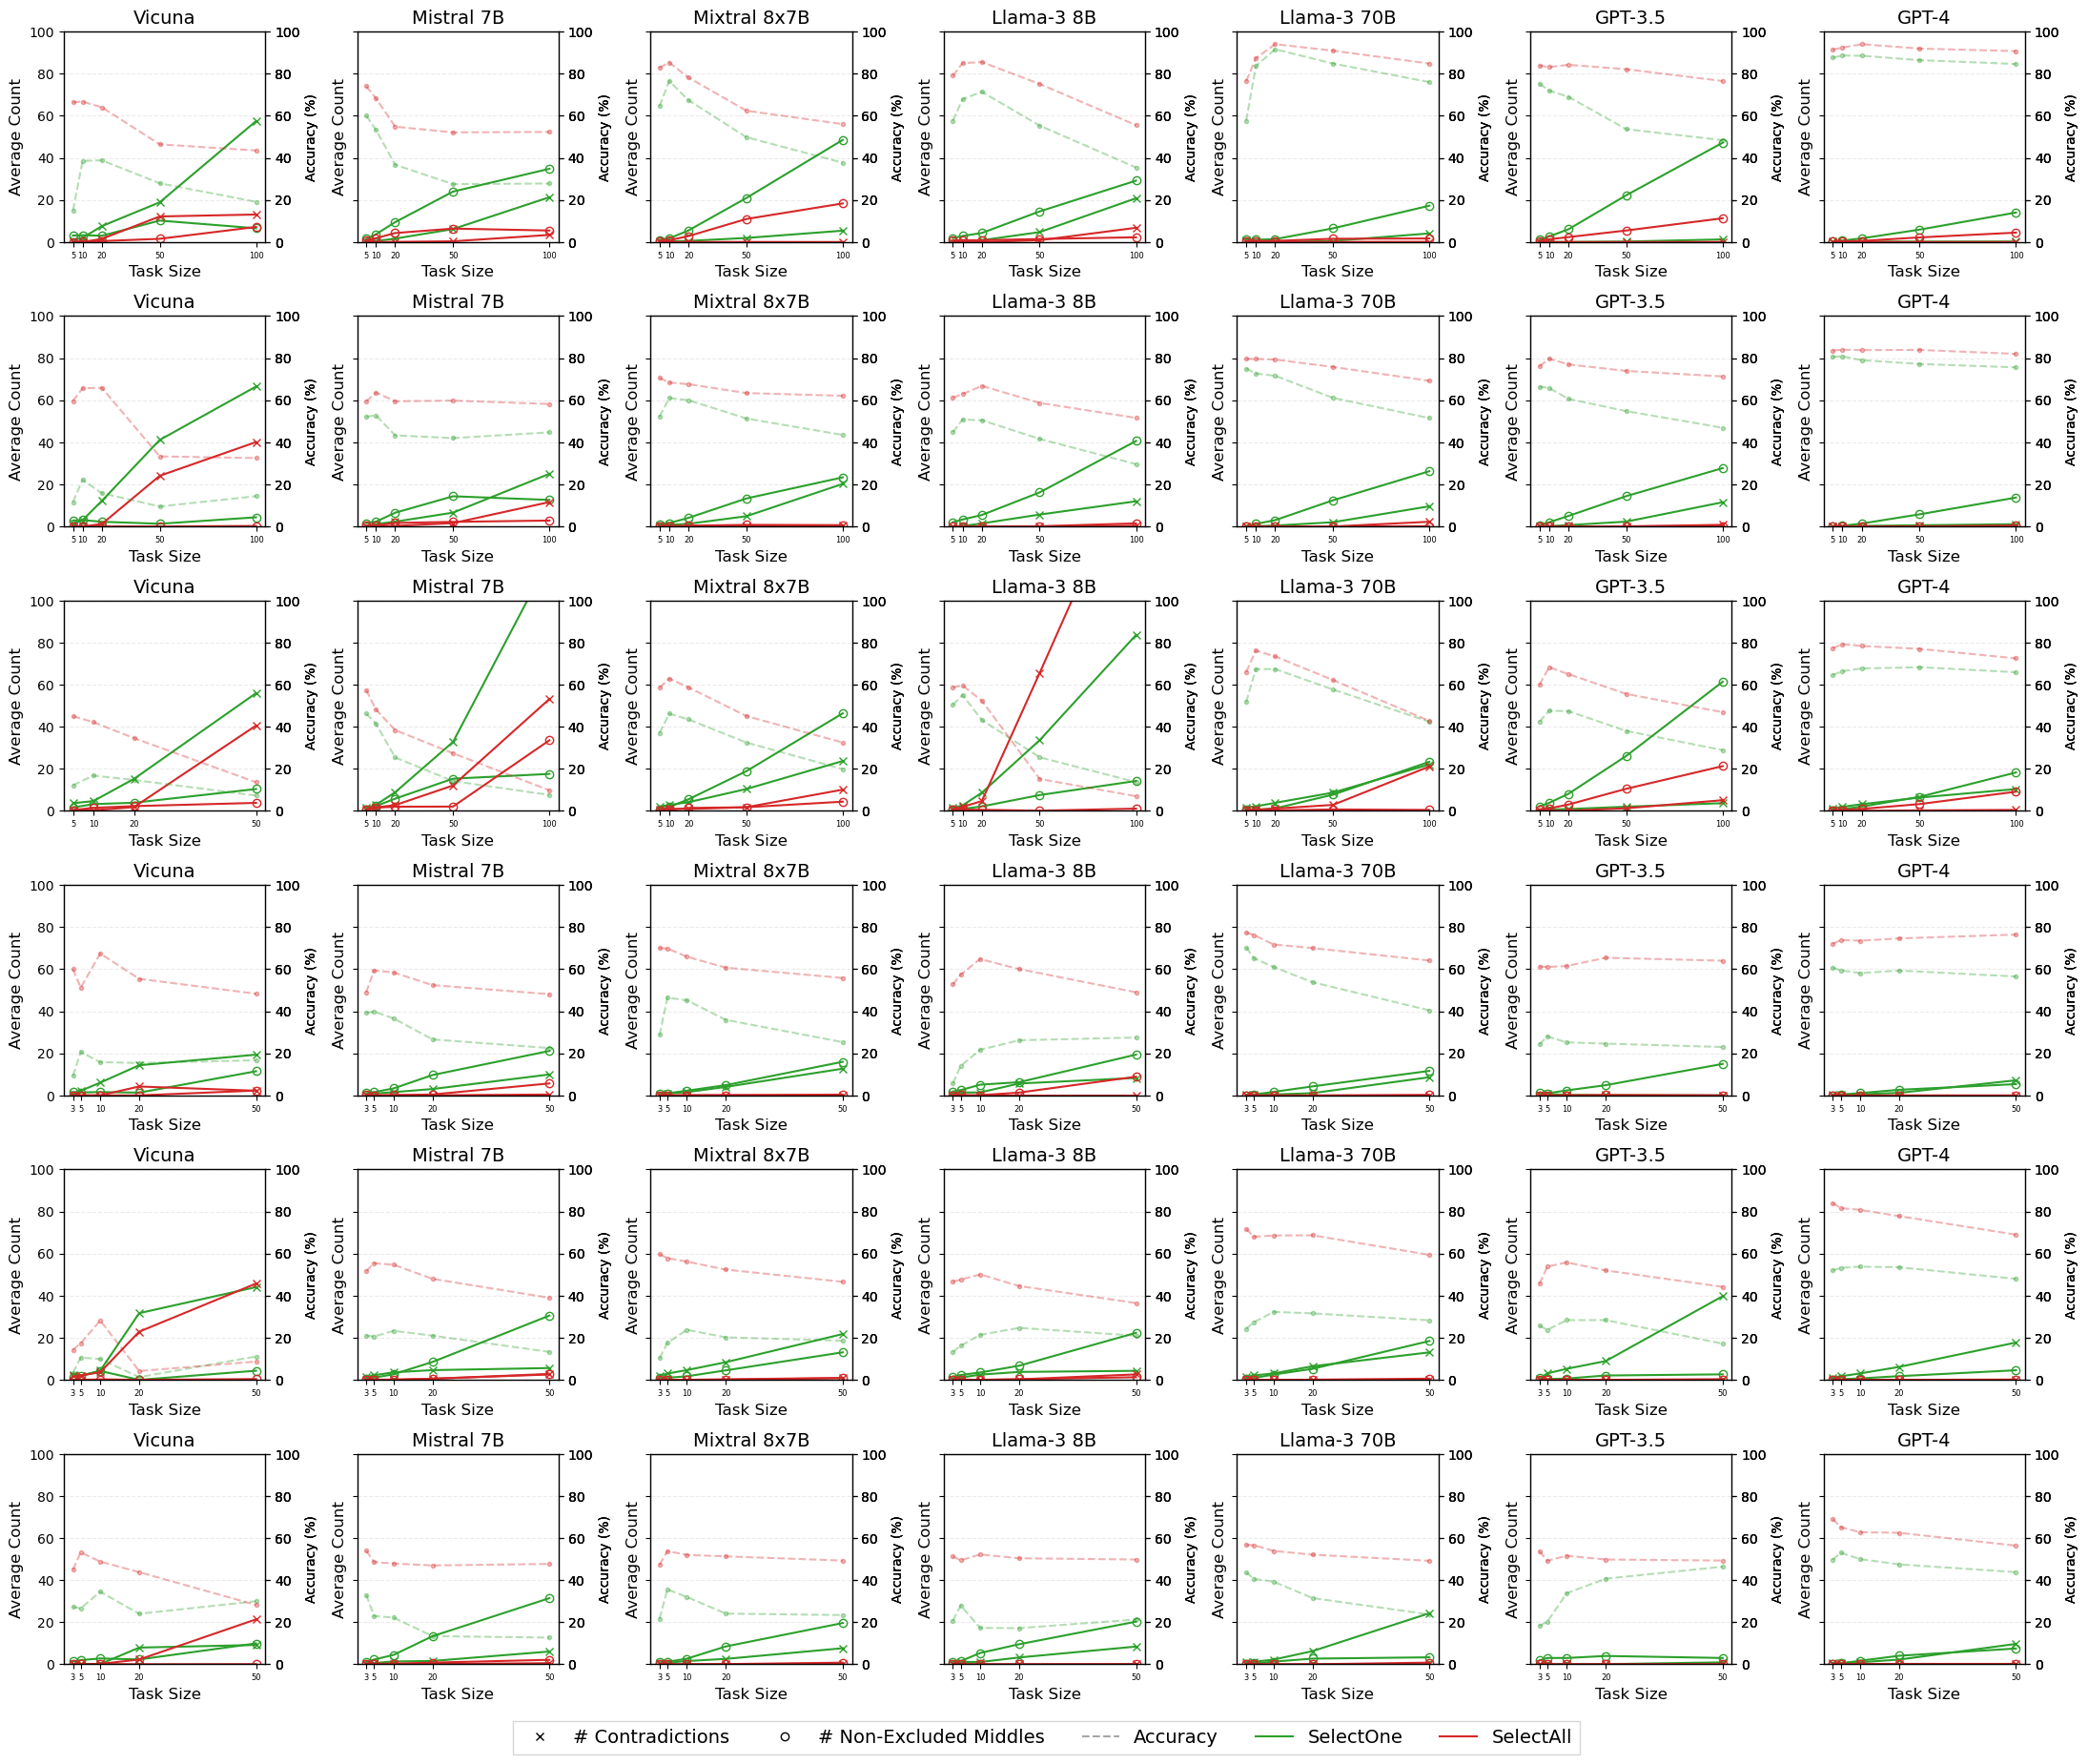

In [87]:
# add a twin y-axis to the plot to show the accuracy of the two tasks with the same model and taskSize in lower alpha

task2color = {"SingleClf": "tab:blue", "BatchClf": "tab:orange", "SelectOne": "tab:green", "SelectAll": "tab:red"}
fig, axs = plt.subplots(6, 7, figsize=(22, 19), sharey=True)
metric2marker = {"#contradictions": "x", "#nonExcludedMiddles": "o"}
models = ['Vicuna', 'Mistral 7B', 'Mixtral 8x7B', 'Llama-3 8B', 
          'Llama-3 70B', 'GPT-3.5', 'GPT-4']

for i, model in enumerate(models):
    for j, benchmark in enumerate(benchmarks):
        sub = selection_df.copy()[(selection_df.model == model) & (selection_df.benchmark == benchmark)]
        taskSizes = sorted(sub.taskSize.unique())
        ax = axs[j][i]

        for task in tasks:
            subsub = sub[sub.task == task]
            for metric in ["#contradictions", "#nonExcludedMiddles"]:
                metric_values = []
                for taskSize in taskSizes:
                    metric_value = subsub[subsub.taskSize == taskSize][metric].mean()
                    metric_values.append(metric_value)
                
                ax.plot(taskSizes, metric_values, marker=metric2marker[metric], 
                            linestyle="-", color=task2color[task], mfc='none')
                
            ax_twin = ax.twinx()
            accs = []
            for taskSize in taskSizes:
                acc = subsub[subsub.taskSize == taskSize]["perTaskAccu"].mean()
                accs.append(round(acc, 3) * 100)

            ax_twin.plot(taskSizes, accs, marker='.', linestyle="--", color=task2color[task], alpha=0.35)
            ax_twin.set_ylim(0, 100)

            ax_twin.set_ylabel("Accuracy (%)")
            
            ax.set_title(model, fontsize=14)
            ax.set_xlabel("Task Size", fontsize=12)
            ax.set_xticks(taskSizes)
            ax.set_xticklabels(ax.get_xticks(), fontsize=6)

            ax.set_ylabel("Average Count", fontsize=12)
            ax.grid(axis='y', linestyle='--', alpha=0.25)
            ax.set_ylim(0, 100)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.plot([], [], 'x', color='black', label='# Contradictions')
plt.plot([], [], 'o', color='black', label='# Non-Excluded Middles', mfc='none')
plt.plot([], [], linestyle='--', color='black', alpha=0.35, label='Accuracy')
plt.plot([], [], 'tab:green', label='SelectOne')
plt.plot([], [], 'tab:red', label='SelectAll')

plt.legend(loc='center left', bbox_to_anchor=(-6.55, -0.35), fontsize=14, fancybox=False, shadow=False, ncol=5)
# plt.savefig("plots/selection_tasks_comparison_fullResults.png", bbox_inches='tight', dpi=300)
plt.show()

In [94]:
selection_df.head(1)["jaccardSim"].item()

{'negative': 0.5, 'positive': 0.75}

In [95]:
from tqdm import tqdm
from scripts.evaluate import calculate_jaccardSim

answer_simlarity = []
cols = ["benchmark", "taskIndex", "model", "targetLabel", "ithTargetLabel", 
        "taskSize", "SelectOneOutput", "SelectAllOutput", "groundTruth", "jaccardSim", "SelectOneJS2GT", "SelectAllJS2GT"]

selection_df_all = selection_df.copy()[(selection_df.task == "SelectAll") & 
                                       (selection_df.parsed != "CANNOT_PARSE")]
selection_df_one = selection_df.copy()[(selection_df.task == "SelectOne")]


for benchmark in benchmarks:
    for model in models:
        sub_all = selection_df_all.copy()[(selection_df_all.benchmark == benchmark) & 
                                          (selection_df_all.model == model)]
        sub_one = selection_df_one.copy()[(selection_df_one.benchmark == benchmark) & 
                                          (selection_df_one.model == model)]
        for taskSize in sorted(sub_all.taskSize.unique()):
            subsub_all = sub_all.copy()[sub_all.taskSize == taskSize]
            subsub_one = sub_one.copy()[sub_one.taskSize == taskSize]

            for taskIndex in sorted(subsub_all.taskIndex.unique()):
                subsubsub_all = subsub_all.copy()[subsub_all.taskIndex == taskIndex]
                subsubsub_one = subsub_one.copy()[subsub_one.taskIndex == taskIndex]

                parsed = subsubsub_all.parsed.item()
                js = subsubsub_all.jaccardSim.item()
                answer = subsubsub_all.answer.item()

                for k in parsed.copy().keys():
                    if k not in answer:
                        parsed.pop(k)

                for i, targetLabel in enumerate(parsed):

                    selectAllOutput = parsed[targetLabel]
                    SelectAllJS2GT = js[targetLabel]
                    ans = answer[targetLabel]

                    ithTargetLabel = i + 1

                    if targetLabel == "sci/tech":
                        targetLabel = "Sci/Tech"
                    else:
                        targetLabel = targetLabel.capitalize()
                    
                    selectOneOutput = subsubsub_one[subsubsub_one.targetLabel == targetLabel]["parsed"]
                    
                    try:
                        selectOneOutput = selectOneOutput.item()
                    except:
                        selectOneOutput = []

                    if selectOneOutput != "CANNOT_PARSE":
                        jaccardSim = calculate_jaccardSim(set(selectOneOutput), set(selectAllOutput))
                        SelectOneJS2GT = subsubsub_one[subsubsub_one.targetLabel == targetLabel]["jaccardSim"].item()
                        answer_simlarity.append([benchmark, taskIndex, model, targetLabel, ithTargetLabel, 
                                             taskSize, selectOneOutput, selectAllOutput, ans, jaccardSim, SelectOneJS2GT, SelectAllJS2GT])

In [99]:
# answer_simlarity_df = pd.DataFrame(answer_simlarity, columns=cols)
answer_simlarity_df = pd.read_csv("results/answer_simlarity_df.csv")
answer_simlarity_df

,benchmark,taskIndex,model,targetLabel,ithTargetLabel,taskSize,SelectOneOutput,SelectAllOutput,groundTruth,jaccardSim,SelectOneJS2GT,SelectAllJS2GT
0,SST-2,1,Vicuna,Positive,1,5,"[4, 2]","[2, 3, 5]","[2, 3, 4, 5]",0.250000,0.500000,0.750000
1,SST-2,1,Vicuna,Negative,2,5,[2],"[1, 4]",[1],0.000000,0.000000,0.500000
2,SST-2,2,Vicuna,Positive,1,5,"[4, 2]","[2, 4]","[3, 4, 5]",1.000000,0.250000,0.250000
3,SST-2,2,Vicuna,Negative,2,5,"[4, 2]","[1, 3, 5]","[1, 2]",0.000000,0.333333,0.250000
4,SST-2,3,Vicuna,Positive,1,5,[2],"[1, 3]","[1, 2, 3]",0.000000,0.333333,0.666667
...,...,...,...,...,...,...,...,...,...,...,...,...
51928,WiC,98,GPT-4,No,2,50,"[34, 24, 32, 10, 46, 47, 48, 29, 16, 36, 9, 23...","[6, 8, 16, 32, 33]","[2, 6, 13, 16, 17, 19, 20, 21, 22, 26, 27, 28,...",0.097561,0.454545,0.160000
51929,WiC,99,GPT-4,Yes,1,50,"[34, 15, 32, 47, 29, 36, 9, 26, 42, 30, 44, 28...","[1, 2, 3, 4, 5, 6, 7, 9, 10, 11, 12, 13, 14, 1...","[1, 4, 9, 10, 11, 12, 13, 14, 15, 17, 21, 24, ...",0.604167,0.513514,0.562500
51930,WiC,99,GPT-4,No,2,50,"[34, 15, 24, 32, 46, 48, 16, 9, 23, 8, 40, 38,...","[8, 16]","[2, 3, 5, 6, 7, 8, 16, 18, 19, 20, 22, 23, 27,...",0.066667,0.358974,0.086957
51931,WiC,100,GPT-4,Yes,1,50,"[34, 10, 46, 47, 48, 42, 8, 44, 12, 20, 5, 35,...","[3, 5, 6, 7, 9, 10, 14, 17, 18, 19, 20, 25, 26...","[2, 3, 4, 5, 6, 8, 10, 14, 15, 16, 17, 22, 23,...",0.612903,0.416667,0.500000


In [98]:
# answer_simlarity_df.to_csv("results/answer_simlarity_df.csv", index=False)

In [97]:
answer_simlarity_df.ithTargetLabel.value_counts()

1    20859
2    20810
3     6886
4     3378
Name: ithTargetLabel, dtype: int64

In [100]:
answer_simlarity_df[(answer_simlarity_df.model== "Vicuna") & (answer_simlarity_df.benchmark == "AGNews")]

,benchmark,taskIndex,model,targetLabel,ithTargetLabel,taskSize,SelectOneOutput,SelectAllOutput,groundTruth,jaccardSim,SelectOneJS2GT,SelectAllJS2GT
13955,AGNews,1,Vicuna,Business,1,5,"[4, 2]",[1],"[1, 2, 4]",0.000000,0.666667,0.333333
13956,AGNews,1,Vicuna,Sports,2,5,[3],[5],[5],0.000000,0.000000,1.000000
13957,AGNews,1,Vicuna,World,3,5,"[4, 2]","[2, 4]",['None'],1.000000,0.000000,0.000000
13958,AGNews,1,Vicuna,Sci/Tech,4,5,"[5, 3, 2]",[3],[3],0.333333,0.333333,1.000000
13959,AGNews,2,Vicuna,Business,1,5,[2],"[1, 2]","[1, 2, 3, 5]",0.500000,0.250000,0.500000
...,...,...,...,...,...,...,...,...,...,...,...,...
15550,AGNews,99,Vicuna,Sci/Tech,4,50,"[34, 24, 32, 46, 48, 29, 16, 42, 8, 40, 44, 35...","[4, 6, 8, 10, 12, 14, 15, 17, 19, 20, 23, 25, ...","[32, 1, 2, 3, 33, 34, 38, 8, 41, 10, 15, 47, 1...",0.400000,0.200000,0.270270
15551,AGNews,100,Vicuna,Business,1,50,"[34, 24, 32, 46, 48, 36, 26, 42, 8, 40, 30, 38...","[1, 4, 8, 11, 14, 17, 19, 21, 23, 25, 27, 29, ...","[1, 35, 4, 37, 7, 42, 46, 16, 17, 20, 24, 27]",0.102564,0.178571,0.214286
15552,AGNews,100,Vicuna,Sports,2,50,"[19, 29, 34, 39, 42, 40, 35, 12, 3, 25, 37]","[2, 3, 5, 6, 7, 9, 10, 12, 13, 15, 16, 18, 20,...","[32, 2, 34, 6, 39, 40, 47, 48, 50, 21, 23, 25,...",0.151515,0.250000,0.205882
15553,AGNews,100,Vicuna,World,3,50,"[34, 24, 32, 46, 47, 48, 29, 36, 9, 26, 50, 42...","[4, 8, 11, 14, 17, 19, 21, 23, 25, 27, 29, 31,...","[3, 36, 8, 10, 11, 12, 45, 15, 49, 19, 26, 30]",0.263158,0.181818,0.178571


In [101]:
answer_simlarity_df.columns[-3:]

Index(['jaccardSim', 'SelectOneJS2GT', 'SelectAllJS2GT'], dtype='object')

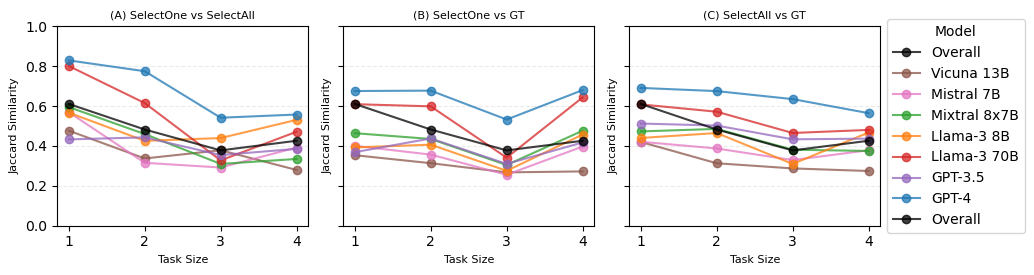

In [96]:
colors = ["black", "tab:brown", "tab:pink",  
          "tab:green", "tab:orange", "tab:red", "tab:purple", "tab:blue",
          "tab:olive", "tab:cyan", "tab:gray"]
models = ["Overall", "Vicuna 13B", "Mistral 7B", "Mixtral 8x7B", 
          "Llama-3 8B", "Llama-3 70B", "GPT-3.5", "GPT-4"]

colorMap = dict(zip(models, colors))

fig, axs = plt.subplots(1, 3, figsize=(9, 3), sharey=True)
indices = ["(A)", "(B)", "(C)"]
ix_ranges = [1,2, 3, 4]

for i, (js, titile) in enumerate(zip(['jaccardSim', 'SelectOneJS2GT', 'SelectAllJS2GT'], 
                           ["SelectOne vs SelectAll", "SelectOne vs GT", "SelectAll vs GT"])):
    ax = axs[i]
    for model in models:
        sims = []
        sub = answer_simlarity_df.copy()[answer_simlarity_df.model == model]
        for ithTargetLabel in ix_ranges:
            subsub = sub.copy()[sub.ithTargetLabel == ithTargetLabel]
            sims.append(subsub[js].mean())
        
        ax.plot(ix_ranges, sims, label=model, color=colorMap[model], marker='o', linestyle='-', alpha=0.75)
        
        ax.set_title(f"{indices[i]} {titile}", fontsize=8)
        ax.set_xlabel("Task Size", fontsize=8)
        ax.set_xticks(ix_ranges)
        ax.set_ylabel("Jaccard Similarity", fontsize=8)
        ax.grid(axis='y', linestyle='--', alpha=0.25)
        ax.set_ylim(0, 1)
    
    overall = []
    for ithTargetLabel in ix_ranges:
        overall.append(answer_simlarity_df[answer_simlarity_df.ithTargetLabel == ithTargetLabel].jaccardSim.mean())
    ax.plot(ix_ranges, overall, label="Overall", color="black", marker='o', linestyle='-', alpha=0.75)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.legend(title="Model", loc='center left', bbox_to_anchor=(1, 0.5))
# plt.savefig("plots/answer_similarity.png", bbox_inches='tight', dpi=300)
plt.show()

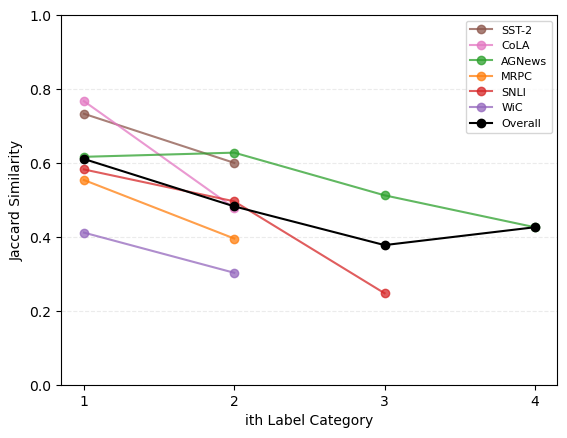

In [114]:
colors = ["black", "tab:brown", "tab:pink",  
          "tab:green", "tab:orange", "tab:red", "tab:purple", "tab:blue",
          "tab:olive", "tab:cyan", "tab:gray"]

colorMap = dict(zip(["Overall"] + benchmarks, colors))


for benchmark in benchmarks:
    sims = []
    ss = answer_simlarity_df[answer_simlarity_df.benchmark == benchmark]
    ix_ranges = sorted(ss.ithTargetLabel.unique())

    for ithTargetLabel in range(1, 5):
        sub = ss[(ss.ithTargetLabel == ithTargetLabel)]
        sims.append(sub.jaccardSim.mean())
    plt.plot(range(1, 5), sims, color=colorMap[benchmark], marker='o', label=benchmark, alpha=0.75)

overall = []
for ithTargetLabel in range(1, 5):
    overall.append(answer_simlarity_df[answer_simlarity_df.ithTargetLabel == ithTargetLabel].jaccardSim.mean())
plt.plot(range(1, 5), overall, label="Overall", marker='o', color="black")


# fontsize: int or {'xx-small', 'x-small', 'small', 'medium', 'large', 'x-large', 'xx-large'}
plt.legend(fontsize=8)
plt.xlabel("ith Label Category")
plt.ylabel("Jaccard Similarity")
plt.ylim(0, 1)
plt.xticks([1,2,3,4])
plt.grid(axis="y", alpha=0.25, linestyle="--")
# plt.savefig("plots/jaccardSim.png", bbox_inches='tight', dpi=300)
plt.show()

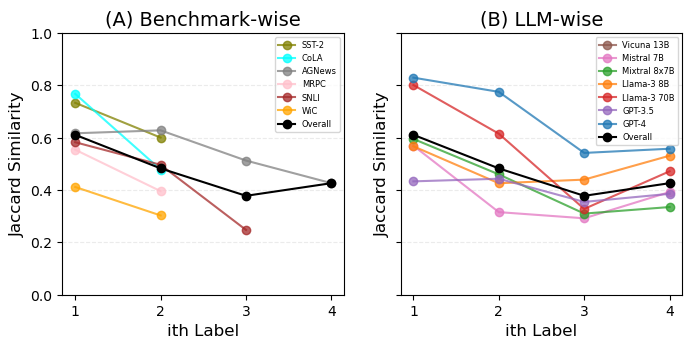

In [102]:
fig, axs = plt.subplots(1, 2, figsize=(8, 3.4), sharey=True)
ax1 = axs[0]
ax2 = axs[1]

colors = ["black", "olive", "cyan", "gray", "pink", "brown", "orange"]

colorMap = dict(zip(["Overall"] + benchmarks, colors))


for benchmark in benchmarks:
    sims = []
    ss = answer_simlarity_df[answer_simlarity_df.benchmark == benchmark]
    ix_ranges = sorted(ss.ithTargetLabel.unique())

    for ithTargetLabel in range(1, 5):
        sub = ss[(ss.ithTargetLabel == ithTargetLabel)]
        sims.append(sub.jaccardSim.mean())
    ax1.plot(range(1, 5), sims, color=colorMap[benchmark], marker='o', label=benchmark, alpha=0.75)

overall = []
for ithTargetLabel in range(1, 5):
    overall.append(answer_simlarity_df[answer_simlarity_df.ithTargetLabel == ithTargetLabel].jaccardSim.mean())
ax1.plot(range(1, 5), overall, label="Overall", marker='o', color=colorMap["Overall"])

ax1.legend(fontsize=6)
ax1.set_xlabel("ith Label", fontsize=12)
ax1.set_ylabel("Jaccard Similarity", fontsize=12)
ax1.set_ylim(0, 1)
ax1.set_xticks([1,2,3,4])
ax1.grid(axis="y", alpha=0.25, linestyle="--")
ax1.set_title("(A) Benchmark-wise", fontsize=14)


colors = ["black", "tab:brown", "tab:pink",  
          "tab:green", "tab:orange", "tab:red", "tab:purple", "tab:blue",
          "tab:olive", "tab:cyan", "tab:gray"]
models = ["Overall", "Vicuna 13B", "Mistral 7B", "Mixtral 8x7B", 
          "Llama-3 8B", "Llama-3 70B", "GPT-3.5", "GPT-4"]

colorMap = dict(zip(models, colors))

for model in models[1:]:
    sims = []
    for ithTargetLabel in range(1, 5):
        sub = answer_simlarity_df[(answer_simlarity_df.model == model) & 
                                  (answer_simlarity_df.ithTargetLabel == ithTargetLabel)]
        sims.append(sub.jaccardSim.mean())
    ax2.plot(range(1, 5), sims, color=colorMap[model], marker='o', label=model, alpha=0.75)

overall = []
for ithTargetLabel in range(1, 5):
    overall.append(answer_simlarity_df[answer_simlarity_df.ithTargetLabel == ithTargetLabel].jaccardSim.mean())
ax2.plot(range(1, 5), overall, label="Overall", marker='o', color=colorMap["Overall"])


# fontsize: int or {'xx-small', 'x-small', 'small', 'medium', 'large', 'x-large', 'xx-large'}
ax2.legend(fontsize=6)
ax2.set_xlabel("ith Label", fontsize=12)
ax2.set_ylabel("Jaccard Similarity", fontsize=12)
ax2.set_ylim(0, 1)
ax2.set_xticks([1,2,3,4])
ax2.grid(axis="y", alpha=0.25, linestyle="--")
ax2.set_title("(B) LLM-wise", fontsize=14)

plt.savefig("plots/jaccardSim.png", bbox_inches='tight', dpi=300)
plt.show()

In [110]:
# colors = ["black", "tab:brown", "tab:pink",  
#           "tab:green", "tab:orange", "tab:red", "tab:purple", "tab:blue",
#           "tab:olive", "tab:cyan", "tab:gray"]
# models = ["Overall", "Vicuna 13B", "Mistral 7B", "Mixtral 8x7B", 
#           "Llama-3 8B", "Llama-3 70B", "GPT-3.5", "GPT-4"]

# colorMap = dict(zip(models, colors))

# fig, axs = plt.subplots(len(benchmarks), 3, figsize=(9, 19), sharey=True)
# indices = ["(A)", "(B)", "(C)"]
# # ix_ranges = [1,2, 3, 4]

# for j, benchmark in enumerate(benchmarks):
#     ss = answer_simlarity_df.copy()[answer_simlarity_df.benchmark == benchmark]
#     ix_ranges = sorted(ss.ithTargetLabel.unique())

#     for i, (js, titile) in enumerate(zip(['jaccardSim', 'SelectOneJS2GT', 'SelectAllJS2GT'], 
#                             ["SelectOne vs SelectAll", "SelectOne vs GT", "SelectAll vs GT"])):
#         ax = axs[j][i]    
#         for model in models:
#             sims = []
#             sub = ss.copy()[(ss.model == model)]

#             for ithTargetLabel in ix_ranges:
#                 subsub = sub.copy()[sub.ithTargetLabel == ithTargetLabel]
#                 sims.append(subsub[js].mean())
            
#             ax.plot(ix_ranges, sims, label=model, color=colorMap[model], marker='o', linestyle='-', alpha=0.75)
            
#             ax.set_title(f"{indices[i]} {titile}", fontsize=8)
#             ax.set_xlabel("Task Size", fontsize=8)
#             ax.set_xticks(ix_ranges)
#             ax.set_ylabel("Jaccard Similarity", fontsize=8)
#             ax.grid(axis='y', linestyle='--', alpha=0.25)
#             ax.set_ylim(0, 1)
        
#         overall = []
#         for ithTargetLabel in ix_ranges:
#             overall.append(answer_simlarity_df[answer_simlarity_df.ithTargetLabel == ithTargetLabel].jaccardSim.mean())
#         ax.plot(ix_ranges, overall, label="Overall", color="black", marker='o', linestyle='-', alpha=0.75)

# plt.tight_layout(rect=[0, 0, 1, 0.95])
# plt.legend(title="Model", loc='center left', bbox_to_anchor=(1, 0.5))
# # plt.savefig("plots/answer_similarity.png", bbox_inches='tight', dpi=300)
# plt.show()

In [97]:
# colors = ["black", "tab:brown", "tab:pink",  
#           "tab:green", "tab:orange", "tab:red", "tab:purple", "tab:blue",
#           "tab:olive", "tab:cyan", "tab:gray"]
# models = ["Overall", "Vicuna 13B", "Mistral 7B", "Mixtral 8x7B", 
#           "Llama-3 8B", "Llama-3 70B", "GPT-3.5", "GPT-4"]

# colorMap = dict(zip(models, colors))
# # plt.figure(figsize=(3, 1.5))

# for model in models:
#     sims = []
#     for ithTargetLabel in range(1, 5):
#         sub = answer_simlarity_df[(answer_simlarity_df.model == model) & 
#                                   (answer_simlarity_df.ithTargetLabel == ithTargetLabel)]
#         sims.append(sub.jaccardSim.mean())
#     plt.plot(range(1, 5), sims, color=colorMap[model], marker='o', label=model, alpha=0.75)

# overall = []
# for ithTargetLabel in range(1, 5):
#     overall.append(answer_simlarity_df[answer_simlarity_df.ithTargetLabel == ithTargetLabel].jaccardSim.mean())
# plt.plot(range(1, 5), overall, label="Overall", marker='o', color=colorMap["Overall"])


# # fontsize: int or {'xx-small', 'x-small', 'small', 'medium', 'large', 'x-large', 'xx-large'}
# plt.legend(fontsize=8)
# plt.xlabel("ith Label Category")
# plt.ylabel("Jaccard Similarity")
# plt.ylim(0, 1)
# plt.xticks([1,2,3,4])
# plt.grid(axis="y", alpha=0.25, linestyle="--")
# # plt.savefig("plots/jaccardSim.png", bbox_inches='tight', dpi=300)
# plt.show()

## Cost accuracy ratio

In [42]:
import tiktoken
from transformers import AutoTokenizer
from scripts.llama3_tokenizer import Tokenizer
from mistral_common.tokens.tokenizers.mistral import MistralTokenizer
from mistral_common.protocol.instruct.messages import UserMessage
from mistral_common.tokens.instruct.normalize import InstructRequest


llama_tokenizer = Tokenizer("Meta-Llama-3-8B-Instruct/tokenizer.model")

def get_tokenizer(model):
    model_renamer_inv = {'Llama 70B': 'meta-llama/Llama-3-70b-chat-hf',
                        'Mixtral 8x7B': 'mistralai/Mixtral-8x7B-Instruct-v0.1',
                        'GPT-3.5': 'gpt-3.5-turbo-0125',
                        'Llama 8B': 'meta-llama/Llama-3-8b-chat-hf',
                        'Mistral 7B': 'mistralai/Mistral-7B-Instruct-v0.2',
                        'GPT-4': 'gpt-4-turbo-2024-04-09',
                        'Vicuna 13B': 'lmsys/vicuna-13b-v1.5'}
    model = model_renamer_inv[model]

    if "gpt" in model:
        tokenizer = tiktoken.encoding_for_model(model).encode
    
    elif "llama" in model:
        # if "8b" in model:
        #     tk_fp = "Meta-Llama-3-8B-Instruct/tokenizer.model"
        # elif "70b" in model:
        #     tk_fp = "Meta-Llama-3-70B-Instruct/tokenizer.model"
        tokenizer = lambda text: llama_tokenizer.encode(text, bos=True, eos=True)
    
    elif "Mistral" in model or "Mixtral" in model:
        model_name = {"mistralai/Mistral-7B-Instruct-v0.2": "open-mistral-7b", 
                  "mistralai/Mixtral-8x7B-Instruct-v0.1": "open-mixtral-8x7b"}[model]
    
        tk = MistralTokenizer.from_model(model_name).instruct_tokenizer.encode_instruct
        tokenizer = lambda text: tk(InstructRequest(messages=[UserMessage(content=text),])).tokens

    elif "vicuna" in model.lower():
        tokenizer = AutoTokenizer.from_pretrained("lmsys/vicuna-13b-v1.5").encode
    
    else:
        raise ValueError(f"Unknown model: {model}")
    
    return tokenizer


def get_num_of_tokens(text, tokenizer):
    return len(tokenizer(text))

In [268]:
from scripts.llm import get_completion

test = []
cols = ["prompt", "completion", "model", "actual_prompt_tokens", "actual_completion_tokens", 
        "predicted_prompt_tokens", "predicted_completion_tokens"]

texts = ["Say 'hello.'", "Tell me a short joke."]

for model in evaled_df.model.unique():
    tokenizer = get_tokenizer(model_renamer[model])
    for text in texts:
        r = get_completion(text, model=model, return_all=True)
        completion = r.choices[0].message.content
        test.append([text, completion, model, r.usage.prompt_tokens, r.usage.completion_tokens,
                     get_num_of_tokens(text, tokenizer), 
                     get_num_of_tokens(completion, tokenizer)])

/Users/wzx/anaconda3/envs/clustering/lib/python3.9/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [273]:
test_df = pd.DataFrame(test, columns=cols)
test_df

,prompt,completion,model,actual_prompt_tokens,actual_completion_tokens,predicted_prompt_tokens,predicted_completion_tokens
0,Say 'hello.',Hello!,meta-llama/Llama-3-70b-chat-hf,14,3,6,4
1,Tell me a short joke.,Here's one:\n\nWhy did the computer go to the ...,meta-llama/Llama-3-70b-chat-hf,16,25,8,26
2,Say 'hello.',Hello! It's nice to meet you. Is there someth...,mistralai/Mixtral-8x7B-Instruct-v0.1,13,50,12,58
3,Tell me a short joke.,Why don't scientists trust atoms? Because the...,mistralai/Mixtral-8x7B-Instruct-v0.1,15,31,14,39
4,Say 'hello.',Hello!,gpt-3.5-turbo-0125,11,2,4,2
5,Tell me a short joke.,Why couldn't the bicycle stand up by itself? B...,gpt-3.5-turbo-0125,13,16,6,16
6,Say 'hello.',Hello!,meta-llama/Llama-3-8b-chat-hf,14,3,6,4
7,Tell me a short joke.,Why don't scientists trust atoms?\n\nBecause t...,meta-llama/Llama-3-8b-chat-hf,16,14,8,15
8,Say 'hello.',Hello! How can I help you today?,mistralai/Mistral-7B-Instruct-v0.2,13,10,12,18
9,Tell me a short joke.,Why don't scientists trust atoms?\n\nBecause ...,mistralai/Mistral-7B-Instruct-v0.2,15,17,14,25


In [271]:
conversions = {}

for model in test_df.model.unique():
    sub = test_df[test_df.model == model]
    prompt_tk_difs = (sub.actual_prompt_tokens - sub.predicted_prompt_tokens)
    completion_tk_difs = (sub.actual_completion_tokens - sub.predicted_completion_tokens)

    assert len(set(prompt_tk_difs)) == 1
    assert len(set(completion_tk_difs)) == 1

    conversions[model] = {"prompt": int(prompt_tk_difs.to_list()[0]), 
                          "completion": int(completion_tk_difs.to_list()[0])}

In [28]:
# conversions = {'meta-llama/Llama-3-70b-chat-hf': {'prompt': 8, 'completion': -1},
#                'mistralai/Mixtral-8x7B-Instruct-v0.1': {'prompt': 1, 'completion': -8},
#                'gpt-3.5-turbo-0125': {'prompt': 7, 'completion': 0},
#                'meta-llama/Llama-3-8b-chat-hf': {'prompt': 8, 'completion': -1},
#                'mistralai/Mistral-7B-Instruct-v0.2': {'prompt': 1, 'completion': -8},
#                'gpt-4-turbo-2024-04-09': {'prompt': 7, 'completion': 0},
#                'lmsys/vicuna-13b-v1.5': {'prompt': 8, 'completion': -1}}

conversions

{'meta-llama/Llama-3-70b-chat-hf': {'prompt': 8, 'completion': -1},
 'mistralai/Mixtral-8x7B-Instruct-v0.1': {'prompt': 1, 'completion': -8},
 'gpt-3.5-turbo-0125': {'prompt': 7, 'completion': 0},
 'meta-llama/Llama-3-8b-chat-hf': {'prompt': 8, 'completion': -1},
 'mistralai/Mistral-7B-Instruct-v0.2': {'prompt': 1, 'completion': -8},
 'gpt-4-turbo-2024-04-09': {'prompt': 7, 'completion': 0},
 'lmsys/vicuna-13b-v1.5': {'prompt': 8, 'completion': -1}}

In [29]:
from threading import Thread


sub = evaled_df[evaled_df.task.isin(['single_clf', 'batch_clf'])]
evaled_df["prompt_tokens"] = "NotCalculated"
evaled_df["completion_tokens"] = "NotCalculated"


def fill_token_nums(model):
    subsub = sub.copy()[sub.model == model]
    tokenizer = get_tokenizer(model_renamer[model])
    print(f"Current model: {model}")

    for col in ["prompt", "completion"]:
        subsub[f"{col}_tokens"] = subsub[col].apply(lambda x: get_num_of_tokens(x, tokenizer) + conversions[model][col])
        print(f"{model}: {col}_tokens computed for {col}.")
    
    for col in ["prompt", "completion"]:
        for i in subsub.index:
            evaled_df.at[i, f"{col}_tokens"] = subsub.at[i, f"{col}_tokens"]
        print(f"{model}: {col}_tokens filled for {col}.")

threads = []
for model in sub.model.unique():
    t = Thread(target=fill_token_nums, args=(model,))
    t.start()
    threads.append(t)

for t in threads:
    t.join()

Current model: meta-llama/Llama-3-70b-chat-hf
Current model: meta-llama/Llama-3-8b-chat-hf
Current model: mistralai/Mistral-7B-Instruct-v0.2
Current model: mistralai/Mixtral-8x7B-Instruct-v0.1


/Users/wzx/anaconda3/envs/clustering/lib/python3.9/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Current model: gpt-3.5-turbo-0125Current model: gpt-4-turbo-2024-04-09

Current model: lmsys/vicuna-13b-v1.5
mistralai/Mistral-7B-Instruct-v0.2: prompt_tokens computed for prompt.
mistralai/Mixtral-8x7B-Instruct-v0.1: prompt_tokens computed for prompt.
mistralai/Mixtral-8x7B-Instruct-v0.1: completion_tokens computed for completion.
mistralai/Mixtral-8x7B-Instruct-v0.1: prompt_tokens filled for prompt.
mistralai/Mixtral-8x7B-Instruct-v0.1: completion_tokens filled for completion.
mistralai/Mistral-7B-Instruct-v0.2: completion_tokens computed for completion.
mistralai/Mistral-7B-Instruct-v0.2: prompt_tokens filled for prompt.
mistralai/Mistral-7B-Instruct-v0.2: completion_tokens filled for completion.


Token indices sequence length is longer than the specified maximum sequence length for this model (4249 > 4096). Running this sequence through the model will result in indexing errors


gpt-3.5-turbo-0125: prompt_tokens computed for prompt.
gpt-4-turbo-2024-04-09: prompt_tokens computed for prompt.
lmsys/vicuna-13b-v1.5: prompt_tokens computed for prompt.
gpt-3.5-turbo-0125: completion_tokens computed for completion.
gpt-3.5-turbo-0125: prompt_tokens filled for prompt.
gpt-3.5-turbo-0125: completion_tokens filled for completion.
gpt-4-turbo-2024-04-09: completion_tokens computed for completion.
gpt-4-turbo-2024-04-09: prompt_tokens filled for prompt.
gpt-4-turbo-2024-04-09: completion_tokens filled for completion.
lmsys/vicuna-13b-v1.5: completion_tokens computed for completion.
lmsys/vicuna-13b-v1.5: prompt_tokens filled for prompt.
lmsys/vicuna-13b-v1.5: completion_tokens filled for completion.
meta-llama/Llama-3-70b-chat-hf: prompt_tokens computed for prompt.
meta-llama/Llama-3-8b-chat-hf: prompt_tokens computed for prompt.
meta-llama/Llama-3-70b-chat-hf: completion_tokens computed for completion.
meta-llama/Llama-3-70b-chat-hf: prompt_tokens filled for prompt.
met

In [59]:
# evaled_df.to_json("results/main_clf_results.json", orient='records', lines=True)

In [60]:
# evaled_df = pd.read_json("results/main_clf_results.json", lines=True)

In [95]:
evaled_df.model.unique()

array(['meta-llama/Llama-3-70b-chat-hf',
       'mistralai/Mixtral-8x7B-Instruct-v0.1', 'gpt-3.5-turbo-0125',
       'meta-llama/Llama-3-8b-chat-hf',
       'mistralai/Mistral-7B-Instruct-v0.2', 'gpt-4-turbo-2024-04-09',
       'lmsys/vicuna-13b-v1.5'], dtype=object)

In [101]:
evaled_df[(evaled_df.model == 'lmsys/vicuna-13b-v1.5') & 
          (evaled_df.benchmark == 'MRPC') & 
          (evaled_df.task == 'batch_clf') & 
          (evaled_df.taskSize == 50)]["prompt_tokens"].mean().round(0)

3645.0

In [118]:
evaled_df.model.unique().tolist()

['meta-llama/Llama-3-70b-chat-hf',
 'mistralai/Mixtral-8x7B-Instruct-v0.1',
 'gpt-3.5-turbo-0125',
 'meta-llama/Llama-3-8b-chat-hf',
 'mistralai/Mistral-7B-Instruct-v0.2',
 'gpt-4-turbo-2024-04-09',
 'lmsys/vicuna-13b-v1.5']

In [119]:
evaled_df.columns

Index(['benchmark', 'taskIndex', 'prompt', 'answer', 'targetLabel', 'task',
       '#shot', 'CoT', 'taskSize', 'model', 'completion', 'parsed',
       'perTaskAccu', 'jaccardSim', '#dif', '#contradictions',
       '#nonExcludedMiddles', 'prompt_tokens', 'completion_tokens'],
      dtype='object')

In [43]:
model_renamer = {'meta-llama/Llama-3-70b-chat-hf': 'Llama 70B', 
                 'mistralai/Mixtral-8x7B-Instruct-v0.1': 'Mixtral 8x7B', 
                 'gpt-3.5-turbo-0125': 'GPT-3.5', 
                 'meta-llama/Llama-3-8b-chat-hf': 'Llama 8B', 
                 'mistralai/Mistral-7B-Instruct-v0.2': 'Mistral 7B', 
                 'gpt-4-turbo-2024-04-09': 'GPT-4', 
                 'lmsys/vicuna-13b-v1.5': 'Vicuna'}

In [44]:
# pricing = {"gpt-4-turbo-2024-04-09": {"prompt": 10, "completion": 30}, 
#            "gpt-3.5-turbo-0125": {"prompt": 0.5, "completion": 1.5},
#            "meta-llama/Llama-3-8b-chat-hf": {"prompt": 0.2, "completion": 0.2},
#            "meta-llama/Llama-3-70b-chat-hf": {"prompt": 0.9, "completion": 0.9},
#            "mistralai/Mistral-7B-Instruct-v0.2": {"prompt": 0.2, "completion": 0.2},
#            "mistralai/Mixtral-8x7B-Instruct-v0.1": {"prompt": 0.6, "completion": 0.6},
#            "lmsys/vicuna-13b-v1.5": {"prompt": 0.3, "completion": 0.3}}


# for model in pricing.copy():
#     pricing[model_renamer[model]] = pricing[model]

pricing = {'gpt-4-turbo-2024-04-09': {'prompt': 10, 'completion': 30},
 'gpt-3.5-turbo-0125': {'prompt': 0.5, 'completion': 1.5},
 'meta-llama/Llama-3-8b-chat-hf': {'prompt': 0.2, 'completion': 0.2},
 'meta-llama/Llama-3-70b-chat-hf': {'prompt': 0.9, 'completion': 0.9},
 'mistralai/Mistral-7B-Instruct-v0.2': {'prompt': 0.2, 'completion': 0.2},
 'mistralai/Mixtral-8x7B-Instruct-v0.1': {'prompt': 0.6, 'completion': 0.6},
 'lmsys/vicuna-13b-v1.5': {'prompt': 0.3, 'completion': 0.3},
 'GPT-4': {'prompt': 10, 'completion': 30},
 'GPT-3.5': {'prompt': 0.5, 'completion': 1.5},
 'Llama-3 8B': {'prompt': 0.2, 'completion': 0.2},
 'Llama-3 70B': {'prompt': 0.9, 'completion': 0.9},
 'Mistral 7B': {'prompt': 0.2, 'completion': 0.2},
 'Mixtral 8x7B': {'prompt': 0.6, 'completion': 0.6},
 'Vicuna': {'prompt': 0.3, 'completion': 0.3}}

In [45]:
def calculate_CAR(length, taskSize, a):
    c = length / taskSize
    return c / a if a > 0 else None

clf_df = prp_df[(prp_df.task.str.contains("_clf")) 
                 & (prp_df.model != "Random Baseline")]
clf_df = clf_df.copy()[~((clf_df.model == "Vicuna") & 
                         (clf_df.benchmark == "AGNews") & 
                         (clf_df.taskSize == 100))]

model_renamer_inv = {'Llama-3 70B': 'meta-llama/Llama-3-70b-chat-hf',
                        'Mixtral 8x7B': 'mistralai/Mixtral-8x7B-Instruct-v0.1',
                        'GPT-3.5': 'gpt-3.5-turbo-0125',
                        'Llama-3 8B': 'meta-llama/Llama-3-8b-chat-hf',
                        'Mistral 7B': 'mistralai/Mistral-7B-Instruct-v0.2',
                        'GPT-4': 'gpt-4-turbo-2024-04-09',
                        'Vicuna': 'lmsys/vicuna-13b-v1.5'}


for ix in clf_df.index:
    benchmark = clf_df.at[ix, "benchmark"]
    task = clf_df.at[ix, "task"]
    taskSize = clf_df.at[ix, "taskSize"]
    model = clf_df.at[ix, "model"]
    performance = prp_df.at[ix, "performance"]

    sub = evaled_df[(evaled_df.benchmark==benchmark) & 
                    (evaled_df.task==task) & 
                    (evaled_df.taskSize==taskSize) & 
                    (evaled_df.model==model_renamer_inv[model])]
    
    avgInputLen = sub["prompt_tokens"].mean()
    avgOutputLen = sub["completion_tokens"].mean()
    avgInPutOutputLen = avgInputLen + avgOutputLen
    clf_df.at[ix, "avgInputLen"] = avgInputLen
    clf_df.at[ix, "avgOutputLen"] = avgOutputLen
    clf_df.at[ix, "avgInPutOutputLen"] = avgInputLen + avgOutputLen

    clf_df.at[ix, "avgInputLenCAR"] = calculate_CAR(avgInputLen, taskSize, performance)
    clf_df.at[ix, "avgOutputLenCAR"] = calculate_CAR(avgOutputLen, taskSize, performance)
    clf_df.at[ix, "avgInPutOutputLenCAR"] = calculate_CAR(avgInPutOutputLen, taskSize, performance)

    avgInputCost = pricing[model]["prompt"] * avgInputLen
    avgOutputCost = pricing[model]["completion"] * avgOutputLen
    avgInPutOutputCost = avgInputCost + avgOutputCost
    clf_df.at[ix, "avgInputCost"] = avgInputCost
    clf_df.at[ix, "avgOutputCost"] = avgOutputCost
    clf_df.at[ix, "avgInPutOutputCost"] = avgInPutOutputCost

    avgInputCAR = calculate_CAR(avgInputCost, taskSize, performance)
    avgOutputCAR = calculate_CAR(avgOutputCost, taskSize, performance)
    avgInPutOutputCAR = avgInputCAR + avgOutputCAR
    clf_df.at[ix, "avgInputCAR"] = avgInputCAR
    clf_df.at[ix, "avgOutputCAR"] = avgOutputCAR
    clf_df.at[ix, "avgInPutOutputCAR"] = avgInPutOutputCAR

In [46]:
clf_df

,benchmark,task,taskSize,model,CoT,#shot,parse_rate,performance,avgInputLen,avgOutputLen,avgInPutOutputLen,avgInputLenCAR,avgOutputLenCAR,avgInPutOutputLenCAR,avgInputCost,avgOutputCost,avgInPutOutputCost,avgInputCAR,avgOutputCAR,avgInPutOutputCAR
0,SST-2,single_clf,1,Llama-3 70B,False,0,0.996156,0.953322,61.592532,5.866008,67.458539,64.608295,6.153226,70.761521,55.433278,5.279407,60.712685,58.147465,5.537903,63.685369
1,SST-2,single_clf,1,Mixtral 8x7B,False,0,0.998902,0.919824,67.918177,41.820977,109.739154,73.838209,45.466269,119.304478,40.750906,25.092586,65.843493,44.302925,27.279761,71.582687
2,SST-2,single_clf,1,GPT-3.5,False,0,0.995058,0.940143,58.600769,1.000000,59.600769,62.331776,1.063668,63.395444,29.300384,1.500000,30.800384,31.165888,1.595502,32.761390
3,SST-2,single_clf,1,Llama-3 8B,False,0,0.987370,0.923119,61.592532,6.012630,67.605162,66.722189,6.513385,73.235574,12.318506,1.202526,13.521032,13.344438,1.302677,14.647115
4,SST-2,single_clf,1,Mistral 7B,False,0,0.990115,0.842394,67.918177,36.503569,104.421746,80.625163,43.333116,123.958279,13.583635,7.300714,20.884349,16.125033,8.666623,24.791656
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
877,WiC,batch_clf,50,GPT-3.5,False,0,1.000000,0.529200,1771.920000,199.000000,1970.920000,66.965986,7.520786,74.486772,885.960000,298.500000,1184.460000,33.482993,11.281179,44.764172
878,WiC,batch_clf,50,Llama-3 8B,False,0,1.000000,0.541200,1774.880000,1720.410000,3495.290000,65.590540,63.577605,129.168145,354.976000,344.082000,699.058000,13.118108,12.715521,25.833629
879,WiC,batch_clf,50,Mistral 7B,False,0,1.000000,0.497800,2064.270000,875.450000,2939.720000,82.935717,35.172760,118.108477,412.854000,175.090000,587.944000,16.587143,7.034552,23.621695
880,WiC,batch_clf,50,GPT-4,False,0,1.000000,0.671600,1771.920000,199.190000,1971.110000,52.767123,5.931805,58.698928,17719.200000,5975.700000,23694.900000,527.671233,177.954139,705.625372


In [47]:
clf_df.columns

Index(['benchmark', 'task', 'taskSize', 'model', 'CoT', '#shot', 'parse_rate',
       'performance', 'avgInputLen', 'avgOutputLen', 'avgInPutOutputLen',
       'avgInputLenCAR', 'avgOutputLenCAR', 'avgInPutOutputLenCAR',
       'avgInputCost', 'avgOutputCost', 'avgInPutOutputCost', 'avgInputCAR',
       'avgOutputCAR', 'avgInPutOutputCAR'],
      dtype='object')

In [48]:
more = []

for benchmark in clf_df.benchmark.unique():
    b_sub = clf_df[clf_df.benchmark == benchmark]
    for taskSize in b_sub.taskSize.unique():
        subsub = b_sub[b_sub.taskSize == taskSize]
        # avg_performance = subsub["performance"].mean()
        avg_avgInputLen = subsub["avgInputLen"].mean()
        avg_avgOutputLen = subsub["avgOutputLen"].mean()
        avg_avgInPutOutputLen = subsub["avgInPutOutputLen"].mean()
        avg_avgInputLenCAR = subsub["avgInputLenCAR"].mean()
        avg_avgOutputLenCAR = subsub["avgOutputLenCAR"].mean()
        avg_avgInPutOutputLenCAR = subsub["avgInPutOutputLenCAR"].mean()
        avg_avgInputCost = subsub["avgInputCost"].mean()
        avg_avgOutputCost = subsub["avgOutputCost"].mean()
        avg_avgInPutOutputCost = subsub["avgInPutOutputCost"].mean()
        avg_avgInputCAR = subsub["avgInputCAR"].mean()
        avg_avgOutputCAR = subsub["avgOutputCAR"].mean()
        avg_avgInPutOutputCAR = subsub["avgInPutOutputCAR"].mean()

        more.append([benchmark, "-", taskSize, "Overall", "-", "-", "-", "-", 
                     avg_avgInputLen, avg_avgOutputLen, avg_avgInPutOutputLen,
                     avg_avgInputLenCAR, avg_avgOutputLenCAR, avg_avgInPutOutputLenCAR, 
                     avg_avgInputCost, avg_avgOutputCost, avg_avgInPutOutputCost,
                     avg_avgInputCAR, avg_avgOutputCAR, avg_avgInPutOutputCAR])

more = pd.DataFrame(more, columns=clf_df.columns)
clf_df = pd.concat([clf_df, more])

In [49]:
clf_df

,benchmark,task,taskSize,model,CoT,#shot,parse_rate,performance,avgInputLen,avgOutputLen,avgInPutOutputLen,avgInputLenCAR,avgOutputLenCAR,avgInPutOutputLenCAR,avgInputCost,avgOutputCost,avgInPutOutputCost,avgInputCAR,avgOutputCAR,avgInPutOutputCAR
0,SST-2,single_clf,1,Llama-3 70B,False,0,0.996156,0.953322,61.592532,5.866008,67.458539,64.608295,6.153226,70.761521,55.433278,5.279407,60.712685,58.147465,5.537903,63.685369
1,SST-2,single_clf,1,Mixtral 8x7B,False,0,0.998902,0.919824,67.918177,41.820977,109.739154,73.838209,45.466269,119.304478,40.750906,25.092586,65.843493,44.302925,27.279761,71.582687
2,SST-2,single_clf,1,GPT-3.5,False,0,0.995058,0.940143,58.600769,1.000000,59.600769,62.331776,1.063668,63.395444,29.300384,1.500000,30.800384,31.165888,1.595502,32.761390
3,SST-2,single_clf,1,Llama-3 8B,False,0,0.98737,0.923119,61.592532,6.012630,67.605162,66.722189,6.513385,73.235574,12.318506,1.202526,13.521032,13.344438,1.302677,14.647115
4,SST-2,single_clf,1,Mistral 7B,False,0,0.990115,0.842394,67.918177,36.503569,104.421746,80.625163,43.333116,123.958279,13.583635,7.300714,20.884349,16.125033,8.666623,24.791656
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31,WiC,-,3,Overall,-,-,-,-,198.135714,159.881429,358.017143,130.621686,96.432952,227.054638,339.272857,917.631000,1256.903857,179.638240,462.272663,641.910903
32,WiC,-,5,Overall,-,-,-,-,271.997143,204.425714,476.422857,92.938263,68.184127,161.122390,467.065571,1440.339429,1907.405000,137.747035,410.528731,548.275766
33,WiC,-,10,Overall,-,-,-,-,452.394286,294.317143,746.711429,77.537039,49.344981,126.882020,777.563000,1740.536000,2518.099000,117.700358,256.556793,374.257151
34,WiC,-,20,Overall,-,-,-,-,816.974286,389.062857,1206.037143,72.088079,34.236102,106.324182,1401.624286,802.108429,2203.732714,106.504368,60.401337,166.905705


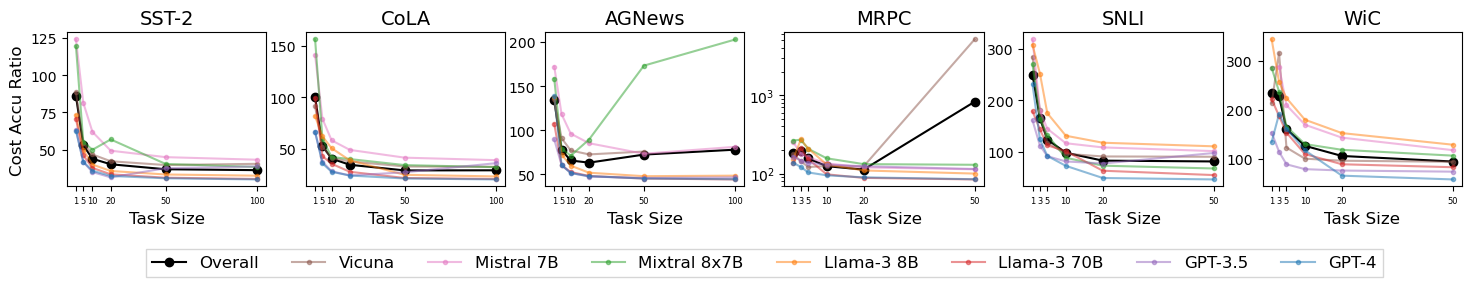

In [138]:
from matplotlib import pyplot as plt

fig, axs = plt.subplots(1, 6, figsize=(18, 2))
colors = ["black", "tab:brown", "tab:pink",  
          "tab:green", "tab:orange", "tab:red", "tab:purple", "tab:blue",
          "tab:olive", "tab:cyan", "tab:gray"]
models = ["Overall", "Vicuna", "Mistral 7B", "Mixtral 8x7B", 
          "Llama-3 8B", "Llama-3 70B", "GPT-3.5", "GPT-4"]

colorMap = dict(zip(models, colors))

for i, benchmark in enumerate(benchmarks):
    ax = axs[i]

    for model in models:
        sub = clf_df[(clf_df.model == model) & (clf_df.benchmark == benchmark)]
        ratios = []

        taskSizes = sorted(sub.taskSize.unique())

        # if model in ["lmsys/vicuna-13b-v1.5", "Overall"] and benchmark == "MRPC":
        #     taskSizes = taskSizes[:-1]

        for taskSize in taskSizes:
            subsub = sub[sub.taskSize == taskSize]
            ratios.append(subsub.avgInPutOutputLenCAR.mean())

        if model not in ["Overall"]:
            ax.plot(taskSizes, ratios, color=colorMap[model], label=model, linestyle="-", marker=".", alpha=0.5)
        else:
            ax.plot(taskSizes, ratios, color=colorMap[model], label=model, linestyle="-", marker="o", alpha=1)

        # ax.plot(taskSizes, ratios, color=colorMap[model], label=model_renamer.get(model, "Overall"), linestyle="-", marker=".", alpha=1)
        ax.set_xlabel("Task Size", fontsize=12)

        if i == 0:
            ax.set_ylabel("Cost Accu Ratio", fontsize=12)
        
        if benchmark == "MRPC":
            ax.set_yscale('log')

        ax.set_title(benchmark, fontsize=14)
        ax.set_xticks(taskSizes)
        ax.set_xticklabels(ax.get_xticks(), fontsize=6)

# plt.legend(title="LLM", loc='center left', bbox_to_anchor=(1, 0.5), 
#             borderpad=0.5, labelspacing=0.5)

plt.legend(loc='upper center', bbox_to_anchor=(-2.5, -0.35), fontsize=12, fancybox=False, shadow=False, ncol=8)
plt.savefig("plots/llm_cost_accu_ratio.png", bbox_inches='tight', dpi=300)
plt.show()

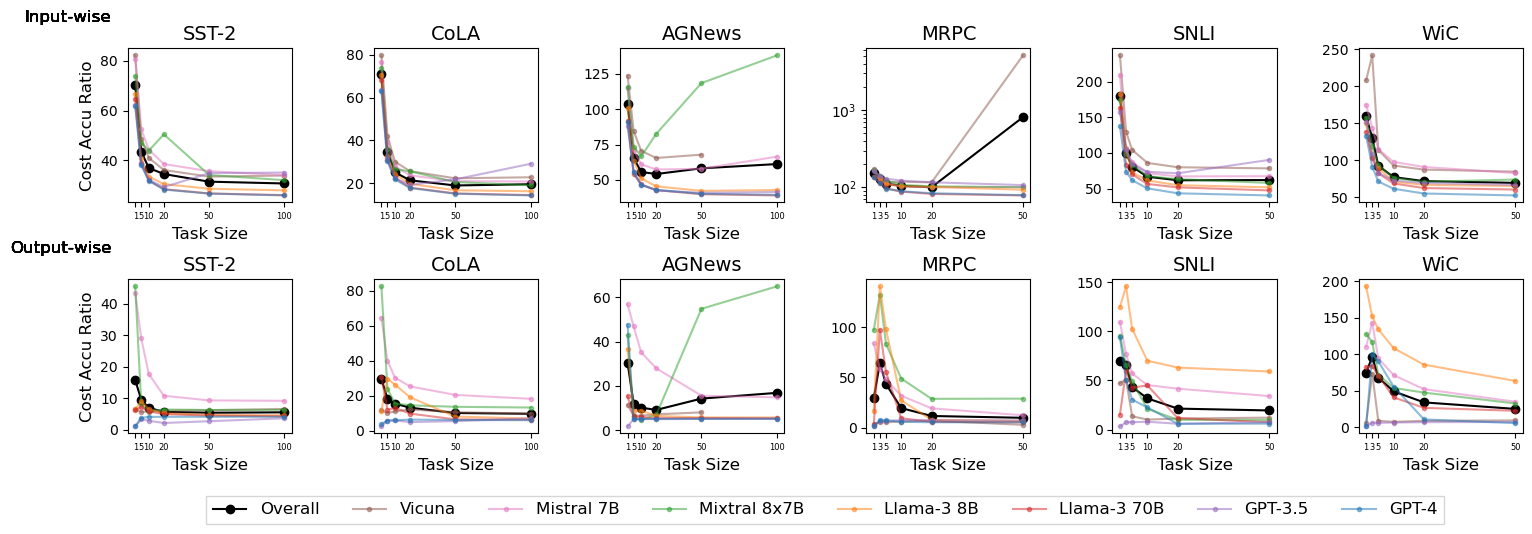

In [77]:
from matplotlib import pyplot as plt

fig, axs = plt.subplots(2, 6, figsize=(18, 5))
# increase the vertical space between the plots
fig.subplots_adjust(hspace=0.5)
# increase the horizontal space between the plots
fig.subplots_adjust(wspace=0.5)

colors = ["black", "tab:brown", "tab:pink",  
          "tab:green", "tab:orange", "tab:red", "tab:purple", "tab:blue",
          "tab:olive", "tab:cyan", "tab:gray"]
models = ["Overall", "Vicuna", "Mistral 7B", "Mixtral 8x7B", 
          "Llama-3 8B", "Llama-3 70B", "GPT-3.5", "GPT-4"]

colorMap = dict(zip(models, colors))

for j, car in enumerate(["avgInputLenCAR", "avgOutputLenCAR"]):

    for i, benchmark in enumerate(benchmarks):
        ax = axs[j][i]

        for model in models:
            sub = clf_df[(clf_df.model == model) & (clf_df.benchmark == benchmark)]
            ratios = []

            taskSizes = sorted(sub.taskSize.unique())

            # if model in ["lmsys/vicuna-13b-v1.5", "Overall"] and benchmark == "MRPC":
            #     taskSizes = taskSizes[:-1]

            for taskSize in taskSizes:
                subsub = sub[sub.taskSize == taskSize]
                ratios.append(subsub[car].mean())

            if model not in ["Overall"]:
                ax.plot(taskSizes, ratios, color=colorMap[model], label=model, linestyle="-", marker=".", alpha=0.5)
            else:
                ax.plot(taskSizes, ratios, color=colorMap[model], label=model, linestyle="-", marker="o", alpha=1)

            # ax.plot(taskSizes, ratios, color=colorMap[model], label=model_renamer.get(model, "Overall"), linestyle="-", marker=".", alpha=1)
            ax.set_xlabel("Task Size", fontsize=12)

            if i == 0:
                ax.set_ylabel("Cost Accu Ratio", fontsize=12)
            
            if j == 0 and benchmark == "MRPC":
                ax.set_yscale('log')

            if j ==0 and i == 0:
                ax.text(-0.1, 1.25, "Input-wise", transform=ax.transAxes, 
                        fontsize=12, va='top', ha='right')
                
            elif j ==1 and i == 0:
                ax.text(-0.1, 1.25, "Output-wise", transform=ax.transAxes, 
                        fontsize=12, va='top', ha='right')
            

            ax.set_title(benchmark, fontsize=14)
            ax.set_xticks(taskSizes)
            ax.set_xticklabels(ax.get_xticks(), fontsize=6)

# plt.legend(title="LLM", loc='center left', bbox_to_anchor=(1, 0.5), 
#             borderpad=0.5, labelspacing=0.5)

plt.legend(loc='upper center', bbox_to_anchor=(-3.25, -0.35), fontsize=12, fancybox=False, shadow=False, ncol=8)
plt.savefig("plots/llm_cost_accu_ratio_input_output.png", bbox_inches='tight', dpi=300)
plt.show()

In [51]:
subsub.columns

Index(['benchmark', 'task', 'taskSize', 'model', 'CoT', '#shot', 'parse_rate',
       'performance', 'avgInputLen', 'avgOutputLen', 'avgInPutOutputLen',
       'avgInputLenCAR', 'avgOutputLenCAR', 'avgInPutOutputLenCAR',
       'avgInputCost', 'avgOutputCost', 'avgInPutOutputCost', 'avgInputCAR',
       'avgOutputCAR', 'avgInPutOutputCAR'],
      dtype='object')

In [115]:
models

['Overall',
 'Vicuna',
 'Mistral 7B',
 'Mixtral 8x7B',
 'Llama-3 8B',
 'Llama-3 70B',
 'GPT-3.5',
 'GPT-4']

In [63]:
clf_df["task"] = clf_df["task"].apply(lambda t: task_renamer.get(t, "-"))
clf_df.head()

,benchmark,task,taskSize,model,CoT,#shot,parse_rate,performance,avgInputLen,avgOutputLen,avgInPutOutputLen,avgInputLenCAR,avgOutputLenCAR,avgInPutOutputLenCAR,avgInputCost,avgOutputCost,avgInPutOutputCost,avgInputCAR,avgOutputCAR,avgInPutOutputCAR
0,SST-2,SingleClf,1,Llama-3 70B,False,0,0.996156,0.953322,61.592532,5.866008,67.458539,64.608295,6.153226,70.761521,55.433278,5.279407,60.712685,58.147465,5.537903,63.685369
1,SST-2,SingleClf,1,Mixtral 8x7B,False,0,0.998902,0.919824,67.918177,41.820977,109.739154,73.838209,45.466269,119.304478,40.750906,25.092586,65.843493,44.302925,27.279761,71.582687
2,SST-2,SingleClf,1,GPT-3.5,False,0,0.995058,0.940143,58.600769,1.000000,59.600769,62.331776,1.063668,63.395444,29.300384,1.500000,30.800384,31.165888,1.595502,32.761390
3,SST-2,SingleClf,1,Llama-3 8B,False,0,0.98737,0.923119,61.592532,6.012630,67.605162,66.722189,6.513385,73.235574,12.318506,1.202526,13.521032,13.344438,1.302677,14.647115
4,SST-2,SingleClf,1,Mistral 7B,False,0,0.990115,0.842394,67.918177,36.503569,104.421746,80.625163,43.333116,123.958279,13.583635,7.300714,20.884349,16.125033,8.666623,24.791656


In [143]:
savings = []
cols = benchmarks
threshold = 0.95

for model in models[1:]:
    sub_savings = []
    for benchmark in benchmarks:
        sub = clf_df[(clf_df.model == model) & (clf_df.benchmark == benchmark)]
        sc = sub[sub.task == "SingleClf"].performance.item()
        sc_avgInPutOutputLen = sub[sub.task == "SingleClf"].avgInPutOutputLen.item()

        for taskSize in sorted(sub.taskSize.unique())[1:]:
            bc = sub[(sub.taskSize == taskSize) & (sub.task == "BatchClf")].performance.item()

            if bc > sc * threshold:
                bc_avgInPutOutputLen = sub[(sub.taskSize == taskSize) & (sub.task == "BatchClf")].avgInPutOutputLen.item() / taskSize
        sub_savings.append((sc_avgInPutOutputLen - bc_avgInPutOutputLen) / sc_avgInPutOutputLen)
    savings.append(sub_savings)

savings_df = pd.DataFrame(savings, columns=cols)
savings_df.index = models[1:]
savings_df

,SST-2,CoLA,AGNews,MRPC,SNLI,WiC
Vicuna,0.521227,0.489319,0.635824,0.306689,0.624563,0.560778
Mistral 7B,0.640413,0.673274,0.515770,0.475838,0.631192,0.650260
Mixtral 8x7B,0.677361,0.741543,0.516845,0.701136,0.718217,0.755074
Llama-3 8B,0.566447,0.707416,0.641881,0.681780,0.534164,0.660104
Llama-3 70B,0.565490,0.787602,0.581367,0.648938,0.613185,0.737356
GPT-3.5,0.507699,0.583347,0.498331,0.632714,0.511822,0.429885
GPT-4,0.511824,0.696366,0.668414,0.409388,0.742342,0.523242


In [144]:
for ix in savings_df.index:
    savings_df.at[ix, "All"] = savings_df.loc[ix].mean()

savings_df = savings_df.round(3) * 100
savings_df

,SST-2,CoLA,AGNews,MRPC,SNLI,WiC,All
Vicuna,52.1,48.9,63.6,30.7,62.5,56.1,52.3
Mistral 7B,64.0,67.3,51.6,47.6,63.1,65.0,59.8
Mixtral 8x7B,67.7,74.2,51.7,70.1,71.8,75.5,68.5
Llama-3 8B,56.6,70.7,64.2,68.2,53.4,66.0,63.2
Llama-3 70B,56.5,78.8,58.1,64.9,61.3,73.7,65.6
GPT-3.5,50.8,58.3,49.8,63.3,51.2,43.0,52.7
GPT-4,51.2,69.6,66.8,40.9,74.2,52.3,59.2


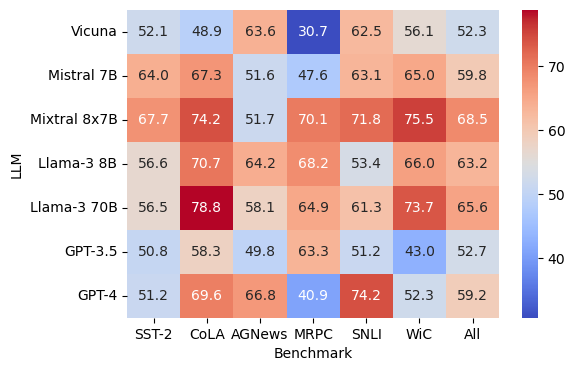

In [129]:
# # make a heatmap of the savings

# import seaborn as sns

# fig, ax = plt.subplots(1, 1, figsize=(6, 4))
# sns.heatmap(savings_df, annot=True, fmt=".1f", cmap="coolwarm", ax=ax)
# ax.set_ylabel("LLM")
# ax.set_xlabel("Benchmark")
# # plt.savefig("plots/llm_best_savings.png", bbox_inches='tight', dpi=300)
# plt.show()

In [147]:
pricing

{'gpt-4-turbo-2024-04-09': {'prompt': 10, 'completion': 30},
 'gpt-3.5-turbo-0125': {'prompt': 0.5, 'completion': 1.5},
 'meta-llama/Llama-3-8b-chat-hf': {'prompt': 0.2, 'completion': 0.2},
 'meta-llama/Llama-3-70b-chat-hf': {'prompt': 0.9, 'completion': 0.9},
 'mistralai/Mistral-7B-Instruct-v0.2': {'prompt': 0.2, 'completion': 0.2},
 'mistralai/Mixtral-8x7B-Instruct-v0.1': {'prompt': 0.6, 'completion': 0.6},
 'lmsys/vicuna-13b-v1.5': {'prompt': 0.3, 'completion': 0.3},
 'GPT-4': {'prompt': 10, 'completion': 30},
 'GPT-3.5': {'prompt': 0.5, 'completion': 1.5},
 'Llama-3 8B': {'prompt': 0.2, 'completion': 0.2},
 'Llama-3 70B': {'prompt': 0.9, 'completion': 0.9},
 'Mistral 7B': {'prompt': 0.2, 'completion': 0.2},
 'Mixtral 8x7B': {'prompt': 0.6, 'completion': 0.6},
 'Vicuna': {'prompt': 0.3, 'completion': 0.3}}

In [104]:
savings = []
cols = benchmarks
threshold = 0.95

for model in models[1:]:
    sub_savings = []
    for benchmark in benchmarks:
        sub = clf_df[(clf_df.model == model) & (clf_df.benchmark == benchmark)]
        sc = sub[sub.task == "SingleClf"].performance.item()
        sc_avgInPutOutputCost = sub[sub.task == "SingleClf"].avgInPutOutputCost.item()

        for taskSize in sorted(sub.taskSize.unique())[1:]:
            bc = sub[(sub.taskSize == taskSize) & (sub.task == "BatchClf")].performance.item()

            if bc > sc * threshold:
                bc_avgInPutOutputCost = sub[(sub.taskSize == taskSize) & (sub.task == "BatchClf")].avgInPutOutputCost.item() / taskSize
        sub_savings.append((sc_avgInPutOutputCost - bc_avgInPutOutputCost) / sc_avgInPutOutputCost)
    savings.append(sub_savings)

savings_df = pd.DataFrame(savings, columns=cols)
savings_df.index = models[1:]
savings_df

,SST-2,CoLA,AGNews,MRPC,SNLI,WiC
Mistral 7B,0.640413,0.673274,0.515770,0.475838,0.631192,0.650260
Mixtral 8x7B,0.677361,0.741543,0.516845,0.701136,0.718217,0.755074
Llama-3 8B,0.566447,0.707416,0.641881,0.681780,0.534164,0.660104
Llama-3 70B,0.565490,0.787602,0.581367,0.648938,0.613185,0.737356
GPT-3.5,0.458456,0.451505,0.409472,0.559837,0.438506,0.363738
GPT-4,0.399954,0.569115,0.758243,0.346941,0.820047,0.378609


In [105]:
for ix in savings_df.index:
    savings_df.at[ix, "All"] = savings_df.loc[ix].mean()

savings_df = savings_df.round(3) * 100
savings_df

,SST-2,CoLA,AGNews,MRPC,SNLI,WiC,All
Mistral 7B,64.0,67.3,51.6,47.6,63.1,65.0,59.8
Mixtral 8x7B,67.7,74.2,51.7,70.1,71.8,75.5,68.5
Llama-3 8B,56.6,70.7,64.2,68.2,53.4,66.0,63.2
Llama-3 70B,56.5,78.8,58.1,64.9,61.3,73.7,65.6
GPT-3.5,45.8,45.2,40.9,56.0,43.9,36.4,44.7
GPT-4,40.0,56.9,75.8,34.7,82.0,37.9,54.5


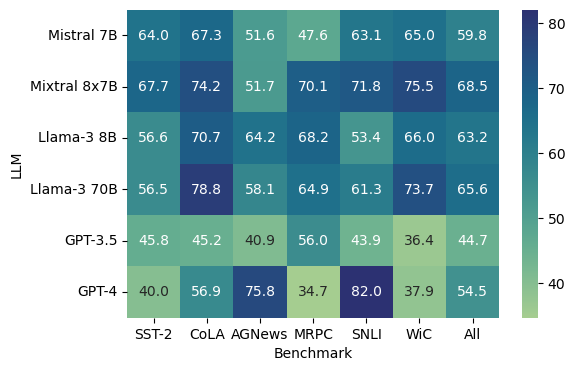

In [107]:
import seaborn as sns

fig, ax = plt.subplots(1, 1, figsize=(6, 4))
sns.heatmap(savings_df, annot=True, fmt=".1f", cmap="crest", ax=ax)
ax.set_ylabel("LLM")
ax.set_xlabel("Benchmark")
plt.savefig("plots/llm_best_savings.png", bbox_inches='tight', dpi=300)
plt.show()

In [153]:
# clf_df

In [76]:
# savings = []
# cols = benchmarks
# threshold = 0.95

# for model in models[1:]:
#     sub_savings = []
#     for benchmark in benchmarks:
#         sub = clf_df[(clf_df.model == model) & (clf_df.benchmark == benchmark)]
#         sc = sub[sub.task == "SingleClf"].performance.item()
#         sc_avgInPutOutputCost = sub[sub.task == "SingleClf"].avgInputCost.item()

#         for taskSize in sorted(sub.taskSize.unique())[1:]:
#             bc = sub[(sub.taskSize == taskSize) & (sub.task == "BatchClf")].performance.item()

#             if bc > sc * threshold:
#                 bc_avgInPutOutputCost = sub[(sub.taskSize == taskSize) & (sub.task == "BatchClf")].avgInputCost.item() / taskSize
#         sub_savings.append((sc_avgInPutOutputCost - bc_avgInPutOutputCost) / sc_avgInPutOutputCost)
#     savings.append(sub_savings)

# savings_df_input = pd.DataFrame(savings, columns=cols).round(3) * 100
# savings_df_input.index = models[1:]
# savings_df_input

In [74]:
# savings = []
# cols = benchmarks
# threshold = 0.95

# for model in models[1:]:
#     sub_savings = []
#     for benchmark in benchmarks:
#         sub = clf_df[(clf_df.model == model) & (clf_df.benchmark == benchmark)]
#         sc = sub[sub.task == "SingleClf"].performance.item()
#         sc_avgInPutOutputCost = sub[sub.task == "SingleClf"].avgOutputCost.item()

#         for taskSize in sorted(sub.taskSize.unique())[1:]:
#             bc = sub[(sub.taskSize == taskSize) & (sub.task == "BatchClf")].performance.item()

#             if bc > sc * threshold:
#                 bc_avgInPutOutputCost = sub[(sub.taskSize == taskSize) & (sub.task == "BatchClf")].avgOutputCost.item() / taskSize
#         sub_savings.append((sc_avgInPutOutputCost - bc_avgInPutOutputCost) / sc_avgInPutOutputCost)
#     savings.append(sub_savings)

# savings_df_output = pd.DataFrame(savings, columns=cols).round(3) * 100
# savings_df_output.index = models[1:]
# savings_df_output

In [75]:
# savings_df_input

In [ ]:
# from matplotlib import pyplot as plt


# fig, axs = plt.subplots(1, 6, figsize=(18, 2))
# colors = ["blue", "green", "red", "purple", "orange", "brown", "pink", "cyan"]
# colorMap = dict(zip(clf_df.model.unique().tolist() + ["Overall"], colors))

# for i, benchmark in enumerate(benchmarks):
#     ax = axs[i]

#     for model in sorted(clf_df.model.unique()):
#         sub = clf_df[(clf_df.model == model) & (clf_df.benchmark == benchmark)]
#         ratios = []

#         taskSizes = sorted(sub.taskSize.unique())

#         # if model in ["lmsys/vicuna-13b-v1.5", "Overall"] and benchmark == "MRPC":
#         #     taskSizes = taskSizes[:-1]

#         for taskSize in taskSizes:
#             subsub = sub[sub.taskSize == taskSize]
#             ratios.append(subsub.avgInPutOutputLenCAR.mean())

#         if model not in ["Llama 70B", "GPT-4", "Overall"]:
#             ax.plot(taskSizes, ratios, color=colorMap[model], label=model, linestyle="-", marker=".", alpha=0.15)
#         else:
#             ax.plot(taskSizes, ratios, color=colorMap[model], label=model, linestyle="-", marker=".", alpha=1)

#         # ax.plot(taskSizes, ratios, color=colorMap[model], label=model_renamer.get(model, "Overall"), linestyle="-", marker=".", alpha=1)
#         ax.set_xlabel("Task Size")

#         if i == 0:
#             ax.set_ylabel("Cost Accu Ratio")
        
#         # if benchmark == "MRPC":
#         #     ax.set_yscale('log')

#         ax.set_title(benchmark)
#         ax.set_xticks(taskSizes)
#         ax.set_xticklabels(ax.get_xticks(), fontsize=6)


# # plt.legend(title="LLM", loc='center left', bbox_to_anchor=(1, 0.5), 
# #             borderpad=0.5, labelspacing=0.5)

# plt.legend(loc='upper center', bbox_to_anchor=(-2.65, -0.35), fancybox=False, shadow=False, ncol=8)
# # plt.savefig("plots/llm_cost_accu_ratio.png", bbox_inches='tight', dpi=300)
# plt.show()

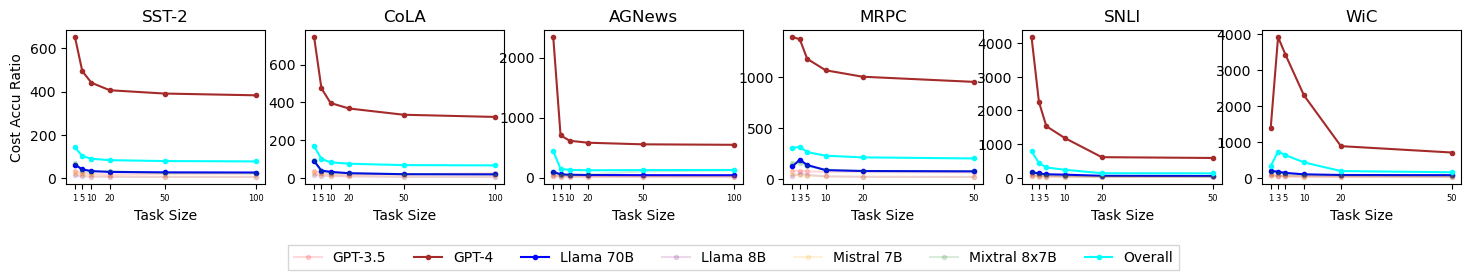

In [74]:
# from matplotlib import pyplot as plt


# fig, axs = plt.subplots(1, 6, figsize=(18, 2))
# colors = ["blue", "green", "red", "purple", "orange", "brown", "pink", "cyan"]
# colorMap = dict(zip(clf_df.model.unique().tolist() + ["Overall"], colors))

# for i, benchmark in enumerate(benchmarks):
#     ax = axs[i]

#     for model in sorted(clf_df.model.unique()):
#         sub = clf_df[(clf_df.model == model) & (clf_df.benchmark == benchmark)]
#         ratios = []

#         taskSizes = sorted(sub.taskSize.unique())

#         # if model in ["lmsys/vicuna-13b-v1.5", "Overall"] and benchmark == "MRPC":
#         #     taskSizes = taskSizes[:-1]

#         for taskSize in taskSizes:
#             subsub = sub[sub.taskSize == taskSize]
#             ratios.append(subsub.avgInPutOutputCAR.mean())

#         if model not in ["Llama 70B", "GPT-4", "Overall"]:
#             ax.plot(taskSizes, ratios, color=colorMap[model], label=model, linestyle="-", marker=".", alpha=0.15)
#         else:
#             ax.plot(taskSizes, ratios, color=colorMap[model], label=model, linestyle="-", marker=".", alpha=1)

#         # ax.plot(taskSizes, ratios, color=colorMap[model], label=model_renamer.get(model, "Overall"), linestyle="-", marker=".", alpha=1)
#         ax.set_xlabel("Task Size")

#         if i == 0:
#             ax.set_ylabel("Cost Accu Ratio")
        
#         # if benchmark == "MRPC":
#         #     ax.set_yscale('log')

#         ax.set_title(benchmark)
#         ax.set_xticks(taskSizes)
#         ax.set_xticklabels(ax.get_xticks(), fontsize=6)


# # plt.legend(title="LLM", loc='center left', bbox_to_anchor=(1, 0.5), 
# #             borderpad=0.5, labelspacing=0.5)

# plt.legend(loc='upper center', bbox_to_anchor=(-2.65, -0.35), fancybox=False, shadow=False, ncol=8)
# # plt.savefig("plots/llm_cost_accu_ratio.png", bbox_inches='tight', dpi=300)
# plt.show()

In [ ]:
# 1_000_000 ==> 2500
# 100_000 * 10 ==> 80 * 10 = 800

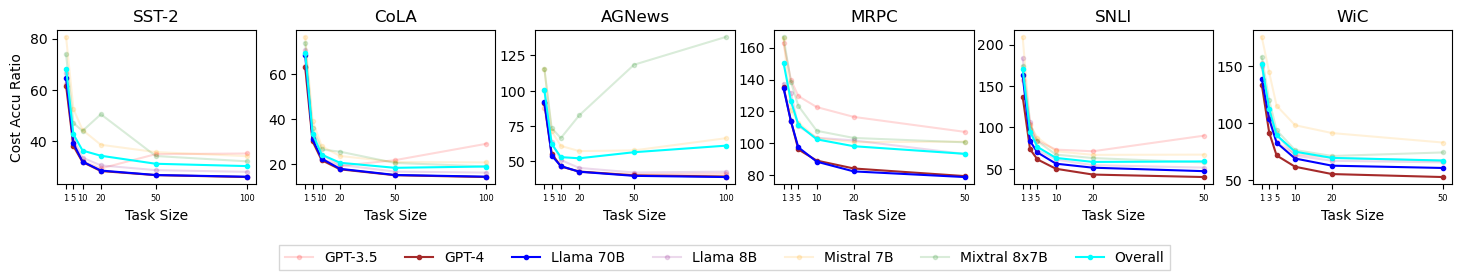

In [71]:
# from matplotlib import pyplot as plt


# fig, axs = plt.subplots(1, 6, figsize=(18, 2))
# colors = ["blue", "green", "red", "purple", "orange", "brown", "pink", "cyan"]
# colorMap = dict(zip(clf_df.model.unique().tolist() + ["Overall"], colors))

# for i, benchmark in enumerate(benchmarks):
#     ax = axs[i]

#     for model in sorted(clf_df.model.unique()):
#         sub = clf_df[(clf_df.model == model) & (clf_df.benchmark == benchmark)]
#         ratios = []

#         taskSizes = sorted(sub.taskSize.unique())

#         # if model in ["lmsys/vicuna-13b-v1.5", "Overall"] and benchmark == "MRPC":
#         #     taskSizes = taskSizes[:-1]

#         for taskSize in taskSizes:
#             subsub = sub[sub.taskSize == taskSize]
#             ratios.append(subsub.avgInputLenCAR.mean())

#         if model not in ["Llama 70B", "GPT-4", "Overall"]:
#             ax.plot(taskSizes, ratios, color=colorMap[model], label=model, linestyle="-", marker=".", alpha=0.15)
#         else:
#             ax.plot(taskSizes, ratios, color=colorMap[model], label=model, linestyle="-", marker=".", alpha=1)

#         # ax.plot(taskSizes, ratios, color=colorMap[model], label=model_renamer.get(model, "Overall"), linestyle="-", marker=".", alpha=1)
#         ax.set_xlabel("Task Size")

#         if i == 0:
#             ax.set_ylabel("Cost Accu Ratio")
        
#         # if benchmark == "MRPC":
#         #     ax.set_yscale('log')

#         ax.set_title(benchmark)
#         ax.set_xticks(taskSizes)
#         ax.set_xticklabels(ax.get_xticks(), fontsize=6)


# # plt.legend(title="LLM", loc='center left', bbox_to_anchor=(1, 0.5), 
# #             borderpad=0.5, labelspacing=0.5)

# plt.legend(loc='upper center', bbox_to_anchor=(-2.65, -0.35), fancybox=False, shadow=False, ncol=8)
# # plt.savefig("plots/llm_cost_accu_ratio.png", bbox_inches='tight', dpi=300)
# plt.show()

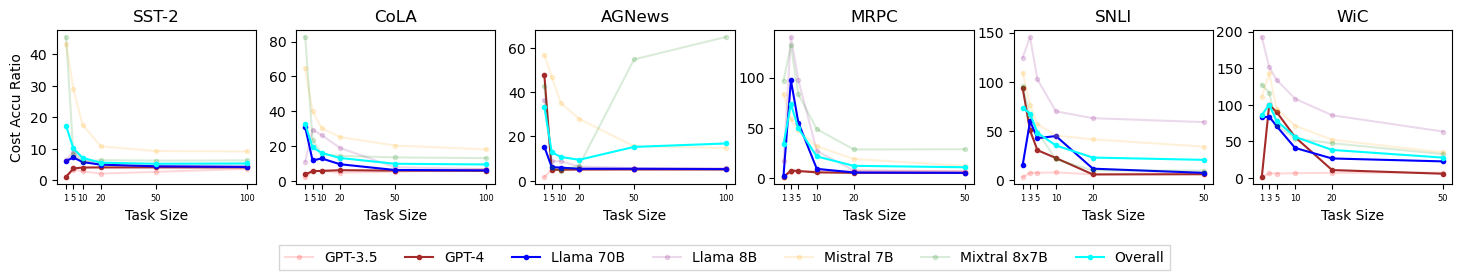

In [73]:
# from matplotlib import pyplot as plt

# fig, axs = plt.subplots(1, 6, figsize=(18, 2))
# colors = ["blue", "green", "red", "purple", "orange", "brown", "pink", "cyan"]
# colorMap = dict(zip(clf_df.model.unique().tolist() + ["Overall"], colors))

# for i, benchmark in enumerate(benchmarks):
#     ax = axs[i]

#     for model in sorted(clf_df.model.unique()):
#         sub = clf_df[(clf_df.model == model) & (clf_df.benchmark == benchmark)]
#         ratios = []

#         taskSizes = sorted(sub.taskSize.unique())

#         # if model in ["lmsys/vicuna-13b-v1.5", "Overall"] and benchmark == "MRPC":
#         #     taskSizes = taskSizes[:-1]

#         for taskSize in taskSizes:
#             subsub = sub[sub.taskSize == taskSize]
#             ratios.append(subsub.avgOutputLenCAR.mean())

#         if model not in ["Llama 70B", "GPT-4", "Overall"]:
#             ax.plot(taskSizes, ratios, color=colorMap[model], label=model, linestyle="-", marker=".", alpha=0.15)
#         else:
#             ax.plot(taskSizes, ratios, color=colorMap[model], label=model, linestyle="-", marker=".", alpha=1)

#         # ax.plot(taskSizes, ratios, color=colorMap[model], label=model_renamer.get(model, "Overall"), linestyle="-", marker=".", alpha=1)
#         ax.set_xlabel("Task Size")

#         if i == 0:
#             ax.set_ylabel("Cost Accu Ratio")
        
#         # if benchmark == "MRPC":
#         #     ax.set_yscale('log')

#         ax.set_title(benchmark)
#         ax.set_xticks(taskSizes)
#         ax.set_xticklabels(ax.get_xticks(), fontsize=6)


# # plt.legend(title="LLM", loc='center left', bbox_to_anchor=(1, 0.5), 
# #             borderpad=0.5, labelspacing=0.5)

# plt.legend(loc='upper center', bbox_to_anchor=(-2.65, -0.35), fancybox=False, shadow=False, ncol=8)
# # plt.savefig("plots/llm_cost_accu_ratio.png", bbox_inches='tight', dpi=300)
# plt.show()